## BANK MARKETING

Projet réalisé par :
* Arnaud Leleu
* Camille Kienlen
* Clément Guillet
* Julien Musschoot

### INTRODUCTION AU PROJET

In [7]:
#Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
import shap
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from IPython.display import Markdown
from IPython.display import Image
from pathlib import Path
from scipy.sparse import csr_matrix
import os, sys

In [8]:
# Chemins d'accès
project_root = Path('.')
data_path = project_root / 'data'
build_path = project_root / 'build'
build_path.mkdir(exist_ok=True)
build_df_path = build_path / 'df'
build_df_path.mkdir(exist_ok=True)
build_graphs_path = build_path / 'graphs'
build_graphs_path.mkdir(exist_ok=True)
build_ml_path = build_path / 'ml'
build_ml_path.mkdir(exist_ok=True)
pages_path = project_root / 'pages'
projet_path = pages_path / '1-projet'
donnees_path = pages_path / '2-donnees'
visu_path = pages_path / '3-visu'
modelisation_path = pages_path / '4-modelisation'
ml_path = pages_path / '5-ml'
conclusion_path = pages_path / '6-conclusion'


# Exploitation d'un fichier .md pour la page de présentation du projet
txt_projet = open(projet_path / 'contexte_et_objectifs.md').read()

# Fichiers exploités sur la page de présentation du jeu de données
txt_cadre = open(donnees_path / 'cadre.md').read()
txt_pertinence = open(donnees_path / 'pertinence.md').read()
df_pertinence = pd.read_csv(donnees_path / "tableau_variables.csv", sep = ";", index_col=0, lineterminator="\n")
txt_conclusion_prepocess = open(donnees_path / 'conclusion_preprocess.md').read()

# Fichiers exploités pour la page de modélisation du projet
txt_classif_choix = open(modelisation_path / 'classification_choix.md').read()
txt_interpretation = open(modelisation_path / 'interpretation.md').read()

# Fichier exploité pour la page de conclusion du projet
txt_conclusion_generale = open(conclusion_path / 'conclusion.md').read()

separation = "-" * 80

# Variables var_num et var_cat
var_num = ["age","balance","duration","campaign","pdays","previous"]
var_cat = ["job","marital","education","default","housing","loan","contact","day","month","poutcome","deposit"]

In [9]:
######## FONCTIONS ########

In [10]:
################ VISUALISATION ################

def create_boxplot(variable, df, build_graphs_path):
    """
    Crée et enregistre un boxplot pour une variable quantitative.
    """
    fig = go.Figure()
    fig.add_trace(go.Box(
        x=df[variable],
        name=variable,
        marker_color="#222A2A",
        opacity=0.7
        ))
    fig.update_layout(
        title=f"Distribution de la variable {variable}",
        plot_bgcolor="rgba(0,0,0,0)",
        xaxis=dict(showgrid=False),
        yaxis=dict(gridcolor="rgba(210,210,210,0.5)")
        )
    full_path = build_graphs_path / f"graph_distrib_var_num_{variable}.png"
    fig.write_image(full_path)
    display(Image(filename=full_path))
    print(f"Graphique enregistré sous {full_path}")
    return fig


def create_histogram(variable, df, filter_condition, bins, xaxis_title, yaxis_title, title, build_graphs_path):
    """
    Crée et enregistre un histogramme comparant deux groupes.
    """
    fig = go.Figure()
    for group, color, name in [("no", "#222A2A", "No"), ("yes", "#19D3F3", "Yes")]:
        fig.add_trace(go.Histogram(
            x=df[(df["deposit"] == group) & filter_condition][variable],
            name=name,
            marker_color=color,
            opacity=0.7,
            nbinsx=bins
            ))
    fig.update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        barmode="group",
        legend_title="Souscription",
        plot_bgcolor="rgba(0,0,0,0)",
        xaxis=dict(showgrid=False),
        yaxis=dict(gridcolor="rgba(210,210,210,0.5)")
        )
    full_path = build_graphs_path / f"graph_histogram_{variable}.png"
    fig.write_image(full_path)
    display(Image(filename=full_path))
    print(f"Histogramme enregistré sous {full_path}")
    return fig


def process_variable(variable, df, build_graphs_path):
    """
    Gère l'analyse d'une variable quantitative, en fonction de sa spécificité.
    """
    print("\n")
    print(f"Variable {variable}")
    
    # Création du boxplot
    create_boxplot(variable, df, build_graphs_path)
    
    # Cas spécifiques
    if variable == "age":
        print("Distribution cohérente, concentrée autour de la médiane, pas de valeurs aberrantes.")
        create_histogram(
            variable=variable,
            df=df,
            filter_condition=(df["age"] >= 0),  # Pas de filtre ici
            bins=75,
            xaxis_title="Âge",
            yaxis_title="Nombre de clients",
            title="Souscription au dépôt selon l'âge",
            build_graphs_path=build_graphs_path
            )
        print("Nous pouvons d’ores et déjà constater que le ratio souscriptions/non-souscriptions est en faveur des prospects âgés de moins de 29 ans ou plus de 60 ans.")
    elif variable == "balance":
        print("Distribution cohérente, concentrée autour de la médiane, pas de valeurs aberrantes.")
        create_histogram(
            variable=variable,
            df=df,
            filter_condition=(df["balance"] > -800) & (df["balance"] < 4000),
            bins=25,
            xaxis_title="Solde bancaire",
            yaxis_title="Nombre de clients",
            title="Souscription au dépôt selon le solde bancaire",
            build_graphs_path=build_graphs_path
            )
        print("Le ratio souscriptions/non-souscriptions est négatif pour les clients dont le solde bancaire est négatif ou faible (inférieur à 800 euros), ce qui parait plutôt cohérent.")
    elif variable == "campaign":
        create_histogram(
            variable=variable,
            df=df,
            filter_condition=(df["campaign"] <= 8),
            bins=8,
            xaxis_title="Nombre d'appels",
            yaxis_title="Nombre de clients",
            title="Souscription au dépôt selon le nombre d'appels",
            build_graphs_path=build_graphs_path
            )
        print("Le ratio gain (souscription) / perte (effort fourni pour le démarchage) semble ne plus être intéressant au-delà d’un appel.")
    elif variable == "pdays":
        create_histogram(
            variable=variable,
            df=df,
            filter_condition=(df["pdays"] >= -1),  # Tous les pdays
            bins=10,
            xaxis_title="Nombre de jours depuis la dernière campagne",
            yaxis_title="Nombre de clients",
            title="Souscription au dépôt selon pdays",
            build_graphs_path=build_graphs_path
            )
        print(separation)
        print("Valeurs prises par pdays quand poutcome est unknown :\n", (df_bank.loc[df_bank["poutcome"] == "unknown"]["pdays"].value_counts()))
        print(separation)
        print("Valeurs prises par poutcome quand pdays est -1 :\n", (df_bank.loc[df_bank["pdays"] == -1]["poutcome"].value_counts()))
        print(separation)
        print("Il y a beaucoup de lignes dont pdays est égal à -1. Pour tous les pdays à -1, poutcome est « unknown » (8 324 valeurs). Pour poutcome à « unknown » (8 863 valeurs au total), pdays varie entre -1 et 391.")
        print("Nous posons le postulat de départ suivant : pdays à -1 et donc par déduction poutcome à « unknown » indique que le client n’a jamais été contacté auparavant pour une campagne précédente. Il s’agit de nouveaux prospects.")
    elif variable == "previous":
        create_histogram(
            variable=variable,
            df=df,
            filter_condition=(df["previous"] < 10),
            bins=10,
            xaxis_title="Nombre de contacts pré-campagne",
            yaxis_title="Nombre de clients",
            title="Souscription au dépôt selon les contacts pré-campagne",
            build_graphs_path=build_graphs_path
            )
        print("Une grande partie des souscriptions lors de cette campagne ont été réalisées par des nouveaux prospects. Néanmoins, le ratio souscription/non-souscription est plus intéressant pour les clients ayant déjà été contactés lors de précédentes campagnes marketing.")
    elif variable == "duration":
        print("Variable 'duration' à analyser pour son importance dans le modèle de Machine Learning.")
    else:
        print("Variable non spécifique, analyse générale appliquée.")


def analyze_categorical_variables(var_cat, df_bank, build_graphs_path):
    """
    Analyse les variables catégorielles et génère les visualisations correspondantes.
    
    Arguments :
    - var_cat : liste des variables catégorielles.
    - df_bank : DataFrame contenant les données.
    - build_graphs_path : chemin pour enregistrer les graphiques.
    """
    for var in var_cat:
        print("\n")
        print("Variable ", var)
        
        # Histogramme pour les variables catégorielles sauf "day" et "month"
        if var not in ("day", "month"):
            fig_var_cat_deposit = go.Figure()
            for group, color, name in [("no", "#222A2A", "No"), ("yes", "#19D3F3", "Yes")]:
                fig_var_cat_deposit.add_trace(go.Histogram(
                    x=df_bank[df_bank["deposit"] == group][var],
                    name=name,
                    marker_color=color,
                    opacity=0.7,
                    nbinsx=12
                    ))
            fig_var_cat_deposit.update_layout(
                title=f"Souscription au dépôt selon la variable {var}",
                xaxis_title=var,
                yaxis_title="Nombre de clients",
                barmode="group",
                legend_title="Souscription",
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis=dict(showgrid=False),
                yaxis=dict(gridcolor="rgba(210,210,210,0.5)")
                )
            full_path = build_graphs_path / f"graph_histo_deposit_{var}.png"
            fig_var_cat_deposit.write_image(full_path)
            display(Image(filename=full_path))
            print(f"Graphique enregistré sous {full_path}")
        
        # Analyse spécifique à certaines variables
        if var == "job":
            print("La variable job comprend très peu de valeurs « unknown » (70 lignes pour une volumétrie totale de plus de 11 000 lignes). Ces lignes peuvent être supprimées.")
            print("Les retraités et étudiants semblent plus enclins à la souscription, confirmant l'analyse par âge.")
        elif var == "education":
            print("Les clients issus d’études supérieures semblent plus enclins à souscrire un dépôt à terme.")
            # Création de l'histogramme éducation par job
            colors = ["#19D3F3", "#4B4B4B", "#1E90FF", "#060808"]
            category_order = ["primary", "secondary", "tertiary", "unknown"]
            fig_educ_job = go.Figure()
            for i, education in enumerate(category_order):
                if education in df_bank["education"].unique():
                    fig_educ_job.add_trace(go.Histogram(
                        x=df_bank[df_bank["education"] == education]["job"],
                        name=education,
                        marker_color=colors[i],
                        opacity=0.7
                        ))
            fig_educ_job.update_layout(
                title="Distribution de la variable education par job",
                xaxis_title="Job",
                yaxis_title="Nombre de clients",
                barmode="group",
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis=dict(showgrid=False),
                yaxis=dict(gridcolor="rgba(210,210,210,0.5)"),
                showlegend=True
                )
            full_path = build_graphs_path / f"graph_histo_educ_par_job.png"
            fig_educ_job.write_image(full_path)
            display(Image(filename=full_path))
            print(f"Graphique enregistré sous {full_path}")
            print("Les variables job et education semblent corrélées entre elles. Pour chaque job, une donnée education semble ressortir clairement de manière générale.")
            print("Le résultat est plus mitigé pour les retraités et entrepreneurs, mais le nombre de clients issus de ces catégories semble suffisamment faible pour pouvoir en faire abstraction.")
            print("Nous pouvons donc en conclure que la variable education, lorsqu’elle est manquante dans le dataset, peut être déduite de la variable job.")
            print("Modalités les plus fréquentes de education par job :")
            print(jobs_education)
        elif var == "marital":
            print("Les clients mariés semblent moins enclins à souscrire. Les célibataires sont de meilleures cibles.")
        elif var == "default":
            print("Données déséquilibrées : très peu de clients en défaut de crédit.")
        elif var == "housing":
            print("Ne pas avoir de crédit immobilier favorise la souscription d’un dépôt.")
        elif var == "loan":
            print("Peu de clients ont un crédit personnel. Ceux qui en ont semblent moins enclins à souscrire.")
        elif var == "contact":
            print("Les téléphones mobiles dominent. La catégorie 'unknown' contient beaucoup de non-souscriptions. Variable non pertinente à supprimer du dataset.")
        elif var == "day":
            # Histogramme deposit / jour de l'appel
            fig_day_deposit = go.Figure()
            fig_day_deposit.add_trace(go.Histogram(
                x=df_bank[df_bank["deposit"] == "no"][var],
                name="No",
                marker_color="#222A2A",
                opacity=0.7,
                nbinsx=31)
                )
            fig_day_deposit.add_trace(go.Histogram(
                x=df_bank[df_bank["deposit"] == "yes"][var],
                name="Yes",
                marker_color="#19D3F3",
                opacity=0.7,
                nbinsx=31)
                )
            fig_day_deposit.update_layout(
                title="Souscription au dépôt selon le jour de l'appel",
                xaxis_title="Jour de l'appel dans le mois",
                yaxis_title="Nombre de clients",
                barmode="group",
                legend_title="Souscription",
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis=dict(showgrid=False),
                yaxis=dict(gridcolor="rgba(210,210,210,0.5)")
                )
            full_path = build_graphs_path / f"graph_histo_deposit_{var}.png"
            fig_day_deposit.write_image(full_path)
            display(Image(filename=full_path))
            print(f"Graphique enregistré sous {full_path}")
            print("Certains jours sont plus propices au démarchage : les 4 premiers jours, le 10, et le 30.")
        elif var == "month":
            # Histogramme deposit / mois de l'appel
            # Création d'un ordre calendaire pour clarifier le graphique suivant
            month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
            df_bank['month'] = pd.Categorical(df_bank['month'], categories=month_order, ordered=True)
            df_bank['month_numeric'] = df_bank['month'].cat.codes
            fig_month_deposit = go.Figure()
            fig_month_deposit.add_trace(go.Histogram(
                x=df_bank[df_bank["deposit"] == "no"]['month_numeric'],
                name="No",
                marker_color="#222A2A",
                opacity=0.7,
                nbinsx=len(month_order))
                )
            fig_month_deposit.add_trace(go.Histogram(
                x=df_bank[df_bank["deposit"] == "yes"]['month_numeric'],
                name="Yes",
                marker_color="#19D3F3",
                opacity=0.7,
                nbinsx=len(month_order))
                )
            fig_month_deposit.update_layout(
                title="Souscription au dépôt selon le mois de l'appel",
                xaxis_title="Mois de l'appel",
                yaxis_title="Nombre de clients",
                barmode="group",
                legend_title="Souscription",
                plot_bgcolor="rgba(0,0,0,0)",
                yaxis=dict(gridcolor="rgba(210,210,210,0.5)"),
                xaxis=dict(showgrid=False, 
                    tickvals=list(range(len(month_order))),
                    ticktext=month_order)
                )
            full_path = build_graphs_path / f"graph_histo_deposit_{var}.png"
            fig_month_deposit.write_image(full_path)
            display(Image(filename=full_path))
            print(f"Graphique enregistré sous {full_path}")
            print("Certains mois (mars, avril, septembre, octobre, décembre) sont plus propices au démarchage.")
        elif var == "poutcome":
            print("Les 'unknown' indiquent de nouveaux prospects. Les 4 catégories actuelles sont conservées.")
        elif var == "deposit":
            print("Variable cible équilibrée, aucune valeur manquante.")

    print("\nAnalyse des variables catégorielles terminée.")

In [11]:
################ ML ################

def plot_shap_values_from_pickles(build_ml_path, num_test, X_test_prepro, prepro, build_graphs_path):
    """
    Affiche l'interprétabilité avec SHAP pour les modèles sauvegardés dans des fichiers Pickle,
    dans un dossier spécifique pour le test choisi.
    
    Arguments:
    - build_ml_path (str): Le répertoire contenant les sous-dossiers des tests.
    - num_test (int): Le numéro du test à charger.
    - X_test_prepro (DataFrame ou np.ndarray): Données de test après prétraitement.
    - prepro (ColumnTransformer): Le transformer utilisé pour les variables.
    - build_graphs_path (str): Chemin du répertoire où les graphiques seront sauvegardés.
    """
    
    test_graphs_folder = Path(build_graphs_path / f"test{num_test}" / "plot_shap")
    test_graphs_folder.mkdir(parents=True, exist_ok=True)
    
    test_folder = Path(build_ml_path, f"test{num_test}")
    
    pickle_path = test_folder / f"ml_test{num_test}_{model_name}_model.pkl"

    if pickle_path.exists():
        with open(pickle_path, "rb") as f:
            model = pickle.load(f)
            
        print(f"Calcul des valeurs SHAP pour le modèle {model_name}...")
        try:
            plot_shap_values(model, X_test_prepro, prepro, model_name, test_graphs_folder)
        except Exception as e:
            print(f"Erreur lors du calcul des valeurs SHAP pour le modèle {model_name}: {e}")
    print(separation)

def plot_shap_values(model, X_test_prepro, prepro, model_name, test_graphs_folder):
    """
    Affiche l'interprétabilité avec SHAP pour un modèle spécifique.
    """

    print(f"Dimensions initiales des données : {X_test_prepro.shape}")


    if len(X_test_prepro.shape) == 3:
        X_test_prepro = X_test_prepro.reshape(X_test_prepro.shape[0], -1)  
        print(f"Dimensions après aplatissement : {X_test_prepro.shape}")


    if isinstance(X_test_prepro, csr_matrix):  
        X_test_prepro = X_test_prepro.toarray()  
    if isinstance(X_test_prepro, np.ndarray): 
        X_test_prepro = pd.DataFrame(X_test_prepro, columns=prepro.get_feature_names_out())


    print(f"Calcul des valeurs SHAP pour {X_test_prepro.shape[0]} exemples...")

   
    if X_test_prepro.shape[0] > 1000:  
        X_test_prepro = X_test_prepro.sample(n=1000, random_state=42)


    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_prepro)

  
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  

    print(f"Dimensions des shap_values avant transformation : {shap_values.shape}")

    if len(shap_values.shape) == 3:

        shap_values = shap_values.mean(axis=2)
    print(f"Dimensions des shap_values après transformation : {shap_values.shape}")


    mean_shap_values = pd.DataFrame(shap_values, columns=prepro.get_feature_names_out()).abs().mean()

    top_5_shap = mean_shap_values.nlargest(5)
    top_shap_importances = pd.DataFrame({'Variables': top_5_shap.index, 'Importance SHAP': top_5_shap.values})

    top_shap_importances["Color"] = top_shap_importances["Variables"].apply(
        lambda x: "deep_blue" if x == "numerical__duration" else "light_blue"
    )
    fig = px.bar(
        top_shap_importances, 
        x="Variables", y="Importance SHAP", 
        color="Color", 
        color_discrete_map={"deep_blue": "#005780", "light_blue": "#19D3F3"},
        title=f"Interprétabilité avec SHAP - Top 5 des variables du modèle {model_name}"
    )
    fig.update_layout(showlegend=False)

    # Sauvegarde et affichage du graphique
    full_path = test_graphs_folder / f"graph_shap_{model_name}.png"
    fig.write_image(full_path)            
    display(Image(filename=full_path))
    print(f"Graphique enregistré sous {full_path}")

In [12]:
display(Markdown(txt_projet))

#### Contexte

##### Contexte d’insertion du projet dans votre métier ou intérêts professionnels

Le projet « bank marketing » nous présente en tant que data analystes pour une banque. La direction de la société nous demande de trouver les meilleures stratégies pour améliorer les prochaines campagnes marketing. Sur la base des informations collectées lors de la dernière campagne, nous devrons identifier les modèles les plus efficaces pour atteindre un objectif bien précis, le succès d’une future campagne de souscription.

Ce projet permet de conjuguer l’analyse avancée de données avec une compréhension approfondie d’enjeux économiques et financiers pour la banque. L’idée est d’améliorer les processus et de fournir à la direction des recommandations stratégiques visant à favoriser la réussite globale de l'entreprise.

##### Dimension Technique

**Utilisation de Python de A à Z :** Nous utiliserons Python au maximum des concepts que nous avons appris pendant notre formation, avec des bibliothèques telles que Pandas pour le traitement des données, Seaborn et Matplotlib pour la visualisation des résultats, et Scikit-learn pour l’analyse prédictive.

Nous articulerons notre progression autour de quatre thèmes principaux.

1. Préparation et nettoyage des données :
    * Traitement des valeurs manquantes : identifier et corriger les données manquantes pour éviter les biais dans le modèle (utilisation de médianes, moyennes, imputation des k proches…)
    * Encodage des variables catégorielles : convertir les variables qualitatives en formats numériques adaptés aux algorithmes de Machine Learning (one hot, label encoding, ordinal encoding)
    * Ajustement des variables : normaliser ou standardiser les variables pour assurer une cohérence dans la modélisation.
2. Analyse exploratoire des données :
    * Identification des schémas : analyser les distributions des données pour détecter des motifs récurrents et des tendances significatives.
    * Exploration des relations : utiliser des visualisations et des statistiques descriptives pour examiner les corrélations entre les variables explicatives et la variable cible (histogrammes, boxplots, heatmaps…).
3. Modélisation prédictive :
    * Sélection et entrainement des modèles : tester et entraîner divers algorithmes de Machine Learning pour déterminer le modèle le plus performant (forêts aléatoires, régressions logistiques, classificateur d’arbre de décision…).
    * Évaluation des performances : mesurer l'efficacité des modèles à l'aide de métriques telles que l’accuracy, la précision, les MAE et MSE, ou encore le f1_score, pour sélectionner le modèle optimal.
4. Développement d'un rapport interactif avec Streamlit :
    * Création du rapport : utiliser Streamlit pour développer un rapport interactif permettant de présenter les résultats de l'analyse et de la modélisation de manière dynamique et accessible. 
    * Présentation des résultats : permettre aux utilisateurs d'explorer les résultats et les insights via une interface web simple, où ils pourront interagir avec les données, filtrer les résultats et visualiser les performances des modèles en temps réel.

##### Dimension Économique

**Amélioration du processus de prise de décision stratégique :** l’utilisation d’un modèle de machine learning permet une analyse facilitée des données dans le but de formuler des recommandations stratégiques pour l’optimisation des résultats des campagnes futures. Cela soutient une prise de décision plus éclairée, permettant de saisir de nouvelles opportunités économiques et limiter les coût financiers d’une campagne marketing.

**Innovation pour la compétitivité :** en introduisant de nouvelles approches analytiques et en optimisant les processus, le projet contribue à l'innovation continue. Cela renforce la compétitivité de l'entreprise qui adopte des pratiques de gestion plus efficaces et améliore la réponse aux évolutions du marché.

#### Objectifs

Nous disposons de données personnelles sur les prospects de la banque ayant été contactés pour souscrire à un "dépôt à terme", ainsi que les résultats de ces opérations (souscription ou non du dépôt à terme suite au télémarketing).

Notre objectif est de prédire le succès d'une campagne marketing en déterminant à l'avance si un client est susceptible de souscrire au produit. Cette prédiction permettra d'optimiser le déploiement de la campagne, en maximisant le taux de souscriptions par rapport au nombre de prospections réalisées.

Pour atteindre cet objectif, nous devrons :
* Cibler les prospects les plus susceptibles de souscrire à un dépôt à terme en établissant un profil type afin d'éviter les prospections inefficaces.
* Déterminer l'approche la plus efficace en optimisant la stratégie de contact pour améliorer les taux de conversion


### COMPREHENSION ET MANIPULATION DES DONNEES

In [13]:
display(Markdown(txt_cadre))

#### Cadre

Le jeu de données dont nous disposons est accessible librement sur la plateforme Kaggle : https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data

Ces données sont sous License CC0: Public Domain

La volumétrie du jeu de données est de 17 colonnes pour 11 162 lignes.

Les données sont de différentes natures (7 entiers, 6 chaînes de caractères, 4 binaires), et se décomposent en 6 variables quantitatives (age, balance, duration, campaign, pdays, previous) et 11 variables catégorielles (job, marital, education, default, housing, loan, contact, day, month, poutcome, deposit).


In [14]:
# Création d'un dataframe pour lire le data set
df_bank = pd.read_csv(data_path / 'bank.csv', sep = ",")

In [15]:
# Exploration macro du dataframe

print("Apercu du dataframe issu du data set bank :")
display(df_bank.head())

Apercu du dataframe issu du data set bank :


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [16]:
# Inspection des données du dataframe

print("Apercu de la structure du dataframe :")
print(df_bank.info())

Apercu de la structure du dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None


Les types de variables associés à chaque colonne sont en accord avec ce que représentent ces colonnes.

In [17]:
display(Markdown(txt_pertinence))

#### Pertinence

La variable la plus importante est la variable binaire « deposit » qui indique si le prospect a finalement souscrit ou non un dépôt à terme suite à la campagne marketing.

Nous devons donc mettre en place un modèle d’apprentissage supervisé suivant la technique de la classification (prédiction d’une variable cible de type qualitatif).

Il nous appartiendra de déterminer la corrélation entre cette variable « deposit » et les autres variables du dataset, pour pouvoir la prédire au final.


#### Pre-processing et feature engineering

In [18]:
# Affichage qualité des données
print("Nombre de valeurs en doublon dans le dataframe :", df_bank.duplicated().sum())
print("\n")

print("Nombre de valeurs manquantes par colonne :")
print(df_bank.isna().sum())
print("\n")

print("Description des variables quantitatives :")
display(df_bank.describe())
print("\n")

print("Valeurs prises par les différentes variables catégorielles :")
print("\n")
for column in df_bank.select_dtypes(include='object').columns:
    print("- " + column + " :")
    print(df_bank[column].unique())
    print("\n")

Nombre de valeurs en doublon dans le dataframe : 0


Nombre de valeurs manquantes par colonne :
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


Description des variables quantitatives :


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000




Valeurs prises par les différentes variables catégorielles :


- job :
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']


- marital :
['married' 'single' 'divorced']


- education :
['secondary' 'tertiary' 'primary' 'unknown']


- default :
['no' 'yes']


- housing :
['yes' 'no']


- loan :
['no' 'yes']


- contact :
['unknown' 'cellular' 'telephone']


- month :
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


- poutcome :
['unknown' 'other' 'failure' 'success']


- deposit :
['yes' 'no']




Le dataframe ne contient aucune valeur manquante à proprement parler mais comprends des champs renseignées unknown à retraiter.

#### Répartition des modalités pour chacune des colonnes :



Variable age


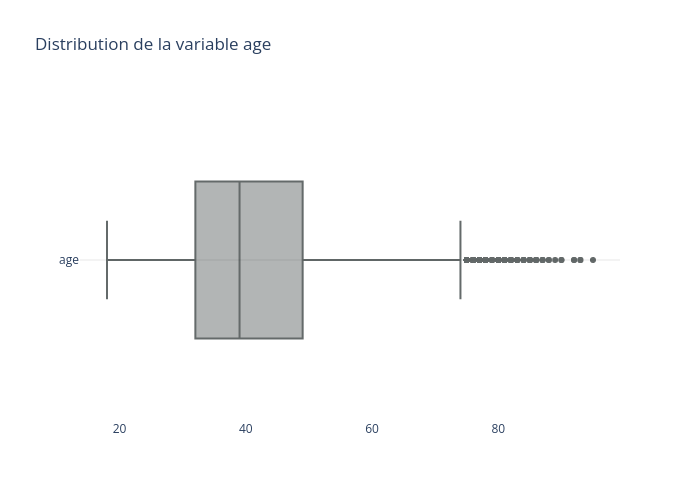

Graphique enregistré sous build/graphs/graph_distrib_var_num_age.png
Distribution cohérente, concentrée autour de la médiane, pas de valeurs aberrantes.


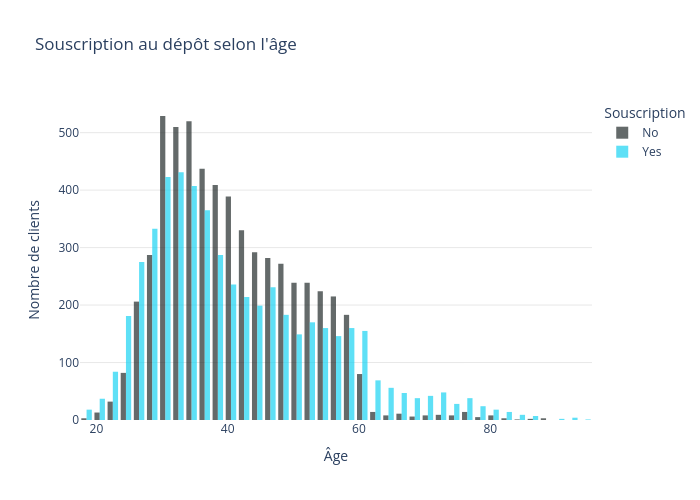

Histogramme enregistré sous build/graphs/graph_histogram_age.png
Nous pouvons d’ores et déjà constater que le ratio souscriptions/non-souscriptions est en faveur des prospects âgés de moins de 29 ans ou plus de 60 ans.


Variable balance


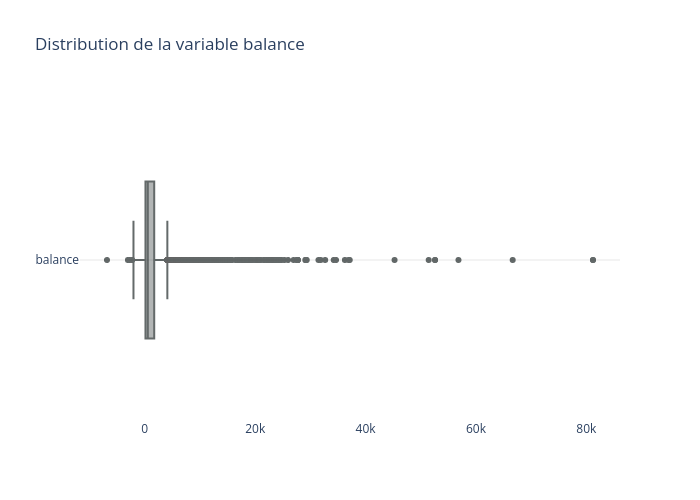

Graphique enregistré sous build/graphs/graph_distrib_var_num_balance.png
Distribution cohérente, concentrée autour de la médiane, pas de valeurs aberrantes.


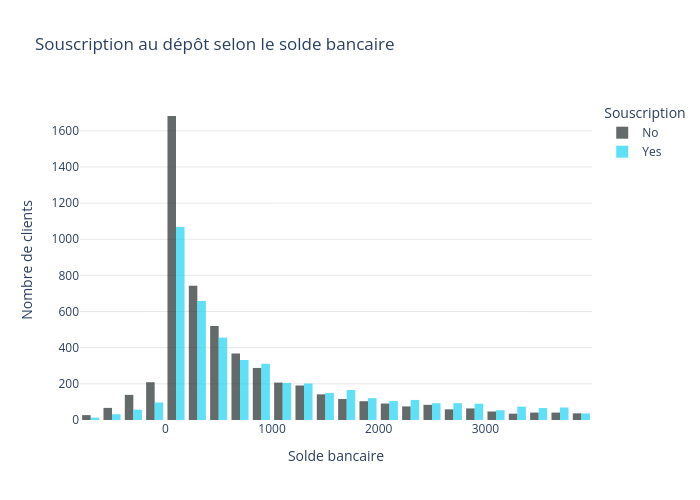

Histogramme enregistré sous build/graphs/graph_histogram_balance.png
Le ratio souscriptions/non-souscriptions est négatif pour les clients dont le solde bancaire est négatif ou faible (inférieur à 800 euros), ce qui parait plutôt cohérent.


Variable duration


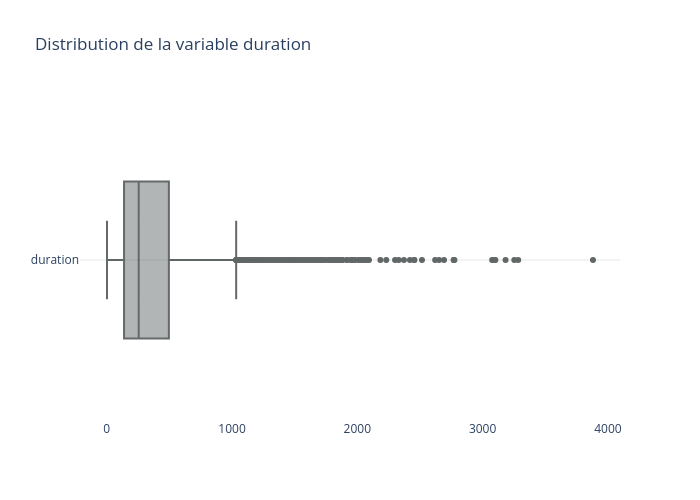

Graphique enregistré sous build/graphs/graph_distrib_var_num_duration.png
Variable 'duration' à analyser pour son importance dans le modèle de Machine Learning.


Variable campaign


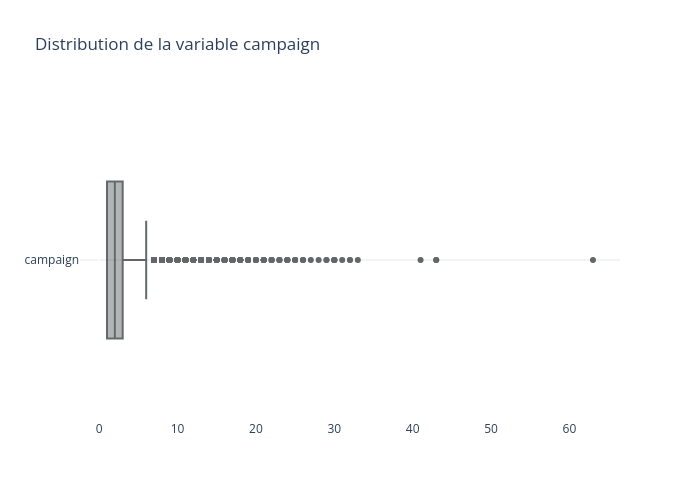

Graphique enregistré sous build/graphs/graph_distrib_var_num_campaign.png


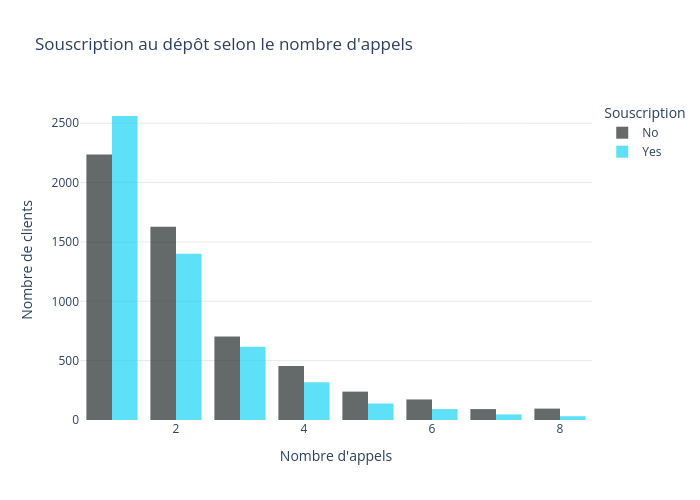

Histogramme enregistré sous build/graphs/graph_histogram_campaign.png
Le ratio gain (souscription) / perte (effort fourni pour le démarchage) semble ne plus être intéressant au-delà d’un appel.


Variable pdays


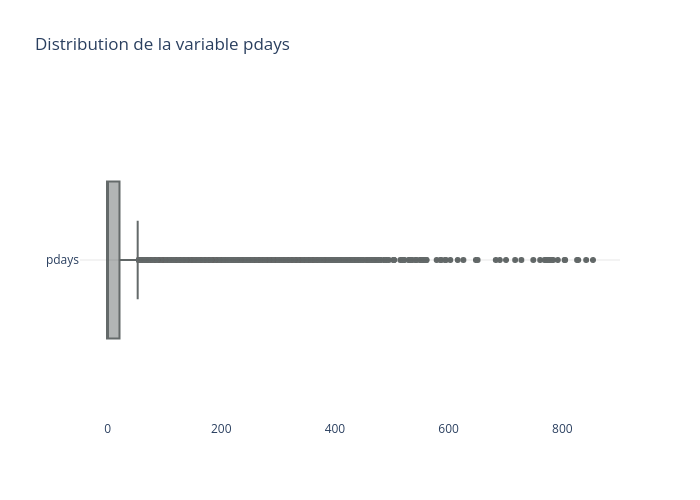

Graphique enregistré sous build/graphs/graph_distrib_var_num_pdays.png


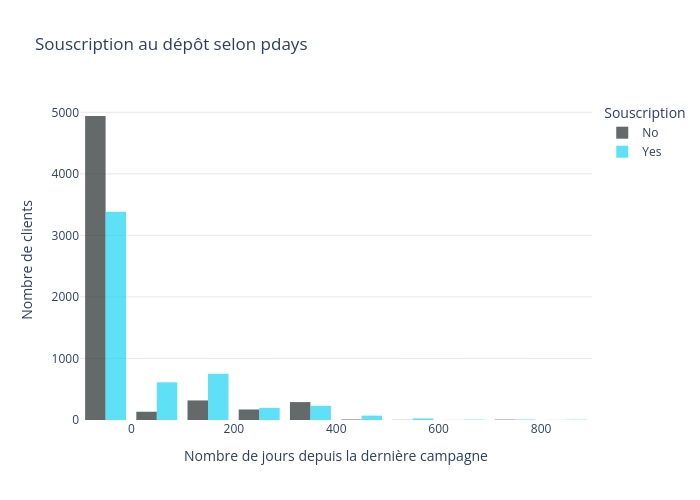

Histogramme enregistré sous build/graphs/graph_histogram_pdays.png
--------------------------------------------------------------------------------
Valeurs prises par pdays quand poutcome est unknown :
 pdays
-1      8324
 188       1
 98        1
Name: count, dtype: int64
--------------------------------------------------------------------------------
Valeurs prises par poutcome quand pdays est -1 :
 poutcome
unknown    8324
Name: count, dtype: int64
--------------------------------------------------------------------------------
Il y a beaucoup de lignes dont pdays est égal à -1. Pour tous les pdays à -1, poutcome est « unknown » (8 324 valeurs). Pour poutcome à « unknown » (8 863 valeurs au total), pdays varie entre -1 et 391.
Nous posons le postulat de départ suivant : pdays à -1 et donc par déduction poutcome à « unknown » indique que le client n’a jamais été contacté auparavant pour une campagne précédente. Il s’agit de nouveaux prospects.


Variable previous


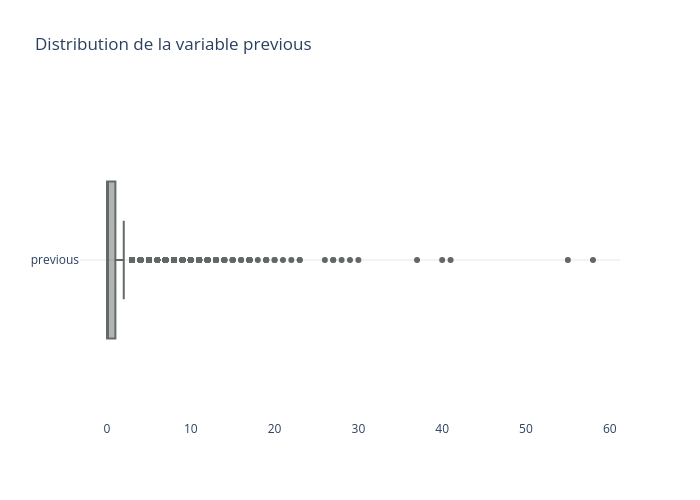

Graphique enregistré sous build/graphs/graph_distrib_var_num_previous.png


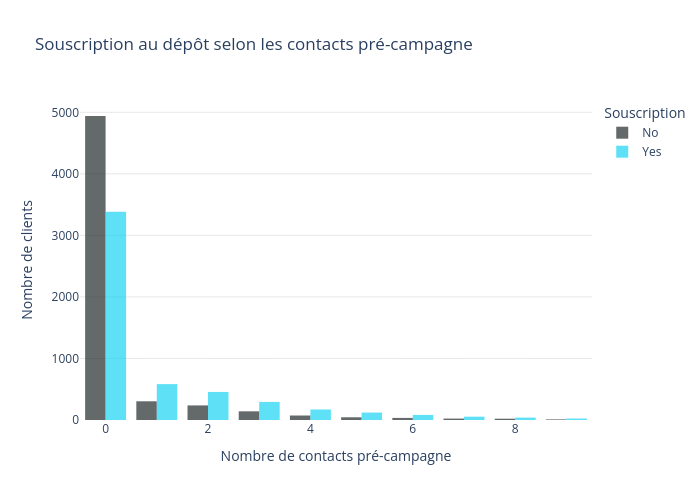

Histogramme enregistré sous build/graphs/graph_histogram_previous.png
Une grande partie des souscriptions lors de cette campagne ont été réalisées par des nouveaux prospects. Néanmoins, le ratio souscription/non-souscription est plus intéressant pour les clients ayant déjà été contactés lors de précédentes campagnes marketing.

Analyse des variables quantitatives terminée.


In [19]:
for var in var_num:
    process_variable(var, df_bank, build_graphs_path)

print("\nAnalyse des variables quantitatives terminée.")

In [20]:
# Variable jobs_education
jobs_education = {}
for element in df_bank["job"].unique():
    selection_job = df_bank.loc[df_bank["job"]== element]
    valeurs_job = selection_job["education"].value_counts()
    mode_job = selection_job["education"].mode()[0]
    jobs_education[element] = mode_job



Variable  job


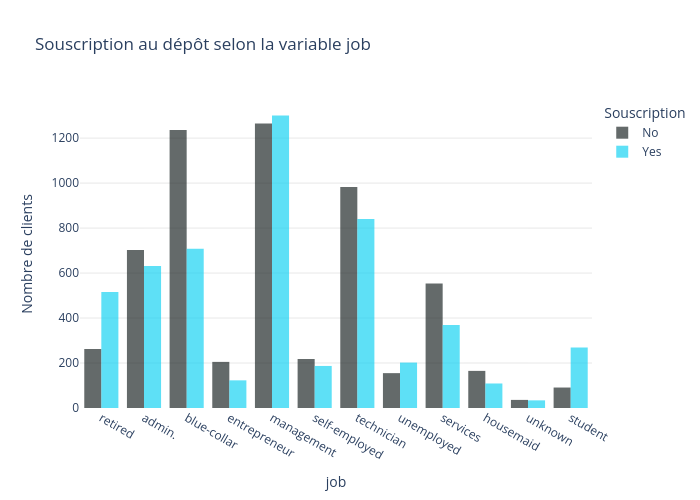

Graphique enregistré sous build/graphs/graph_histo_deposit_job.png
La variable job comprend très peu de valeurs « unknown » (70 lignes pour une volumétrie totale de plus de 11 000 lignes). Ces lignes peuvent être supprimées.
Les retraités et étudiants semblent plus enclins à la souscription, confirmant l'analyse par âge.


Variable  marital


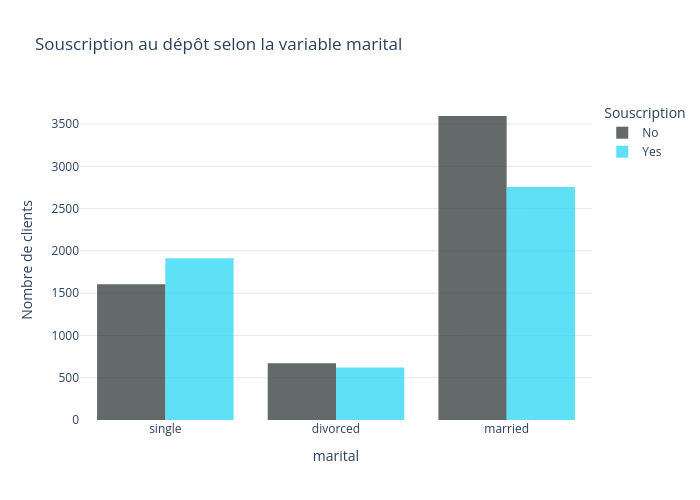

Graphique enregistré sous build/graphs/graph_histo_deposit_marital.png
Les clients mariés semblent moins enclins à souscrire. Les célibataires sont de meilleures cibles.


Variable  education


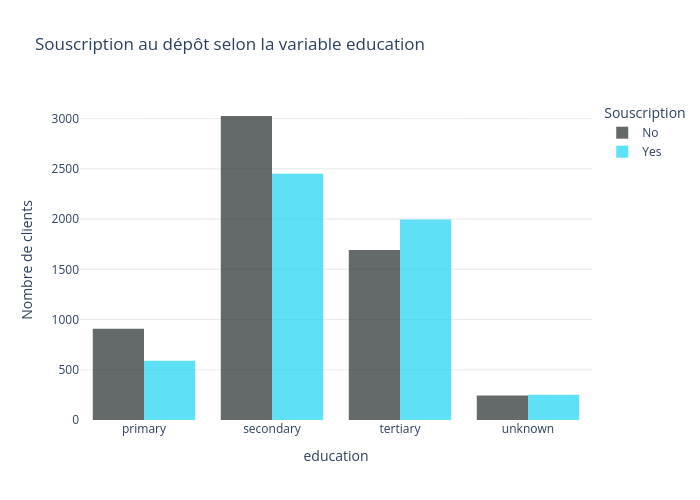

Graphique enregistré sous build/graphs/graph_histo_deposit_education.png
Les clients issus d’études supérieures semblent plus enclins à souscrire un dépôt à terme.


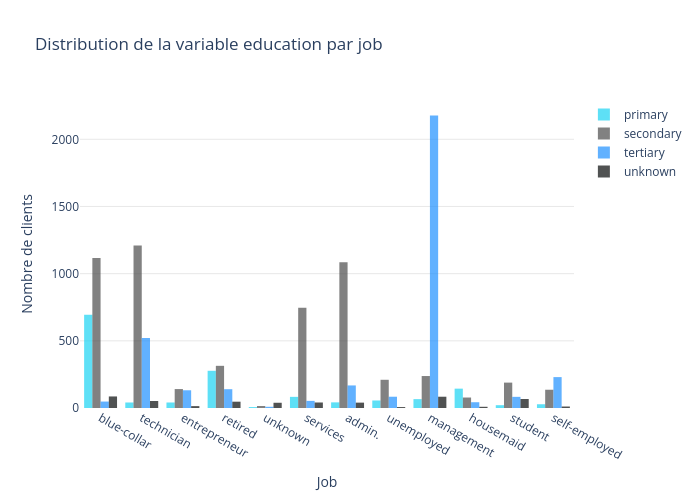

Graphique enregistré sous build/graphs/graph_histo_educ_par_job.png
Les variables job et education semblent corrélées entre elles. Pour chaque job, une donnée education semble ressortir clairement de manière générale.
Le résultat est plus mitigé pour les retraités et entrepreneurs, mais le nombre de clients issus de ces catégories semble suffisamment faible pour pouvoir en faire abstraction.
Nous pouvons donc en conclure que la variable education, lorsqu’elle est manquante dans le dataset, peut être déduite de la variable job.
Modalités les plus fréquentes de education par job :
{'admin.': 'secondary', 'technician': 'secondary', 'services': 'secondary', 'management': 'tertiary', 'retired': 'secondary', 'blue-collar': 'secondary', 'unemployed': 'secondary', 'entrepreneur': 'secondary', 'housemaid': 'primary', 'unknown': 'unknown', 'self-employed': 'tertiary', 'student': 'secondary'}


Variable  default


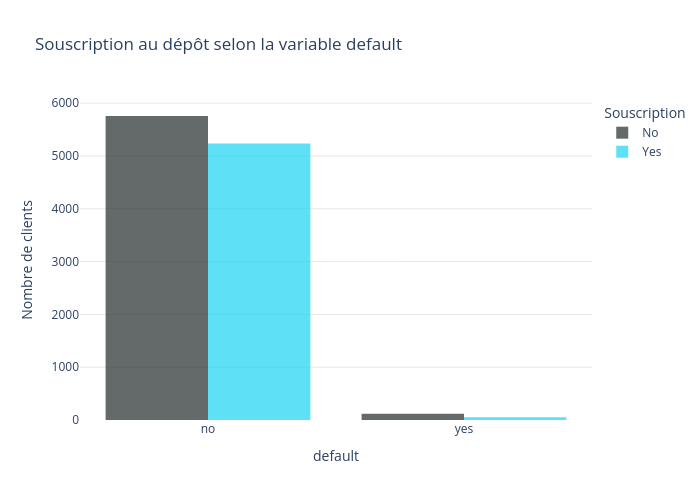

Graphique enregistré sous build/graphs/graph_histo_deposit_default.png
Données déséquilibrées : très peu de clients en défaut de crédit.


Variable  housing


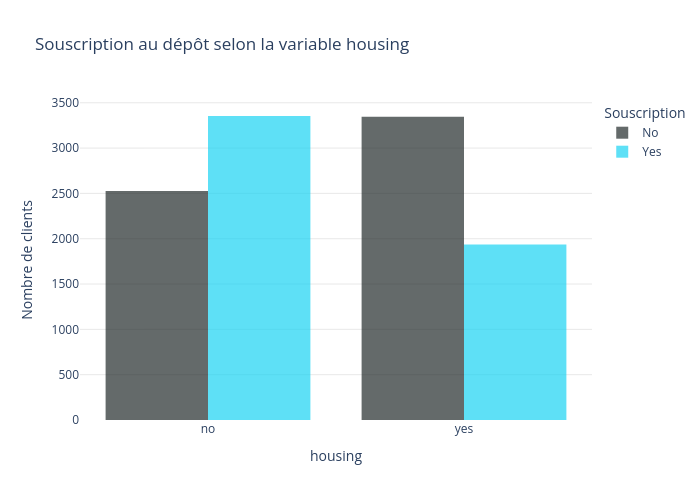

Graphique enregistré sous build/graphs/graph_histo_deposit_housing.png
Ne pas avoir de crédit immobilier favorise la souscription d’un dépôt.


Variable  loan


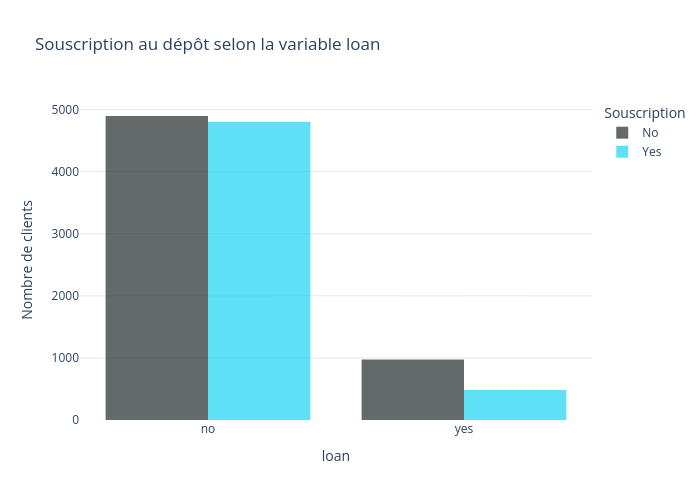

Graphique enregistré sous build/graphs/graph_histo_deposit_loan.png
Peu de clients ont un crédit personnel. Ceux qui en ont semblent moins enclins à souscrire.


Variable  contact


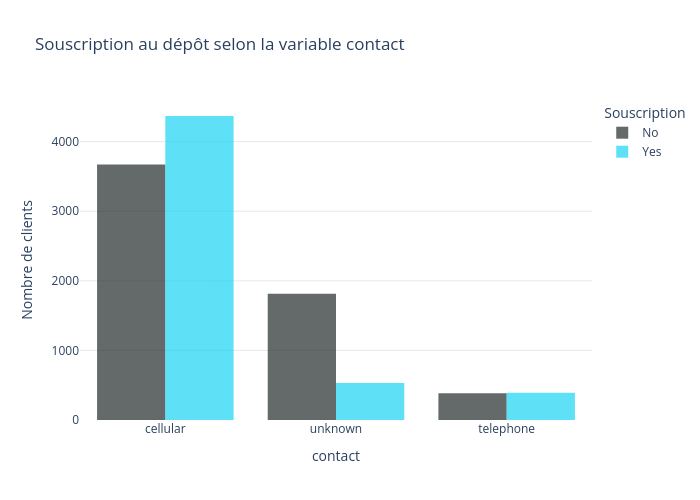

Graphique enregistré sous build/graphs/graph_histo_deposit_contact.png
Les téléphones mobiles dominent. La catégorie 'unknown' contient beaucoup de non-souscriptions. Variable non pertinente à supprimer du dataset.


Variable  day


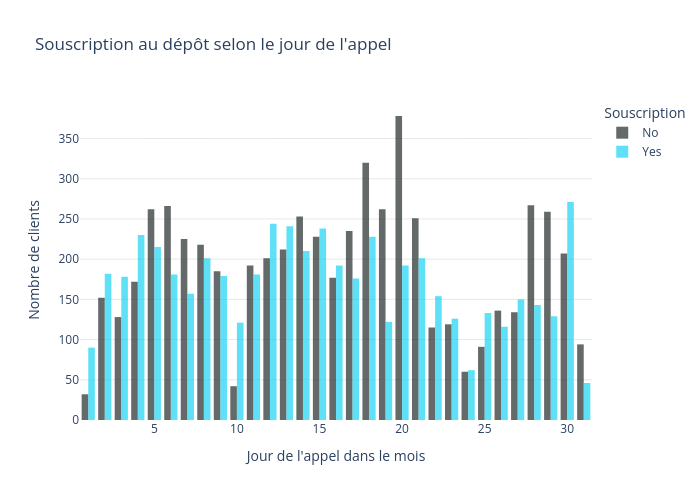

Graphique enregistré sous build/graphs/graph_histo_deposit_day.png
Certains jours sont plus propices au démarchage : les 4 premiers jours, le 10, et le 30.


Variable  month


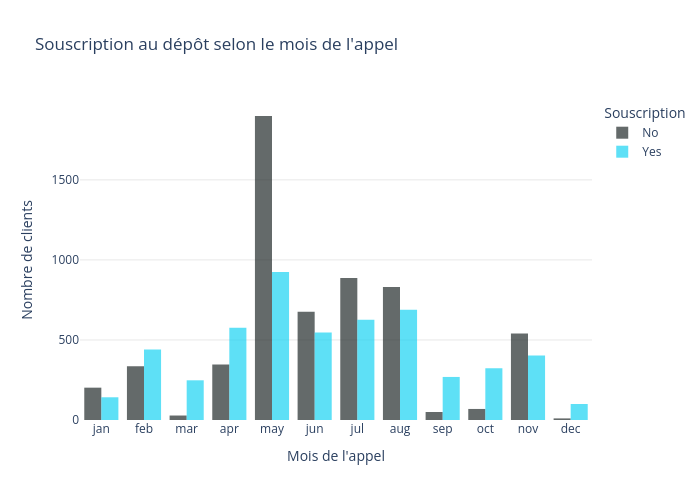

Graphique enregistré sous build/graphs/graph_histo_deposit_month.png
Certains mois (mars, avril, septembre, octobre, décembre) sont plus propices au démarchage.


Variable  poutcome


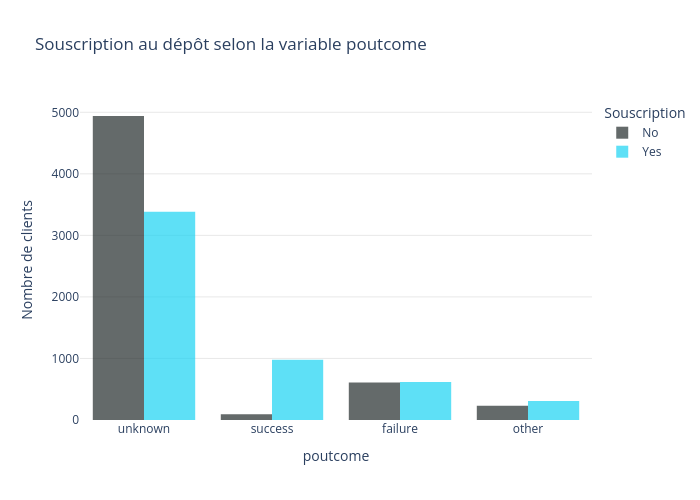

Graphique enregistré sous build/graphs/graph_histo_deposit_poutcome.png
Les 'unknown' indiquent de nouveaux prospects. Les 4 catégories actuelles sont conservées.


Variable  deposit


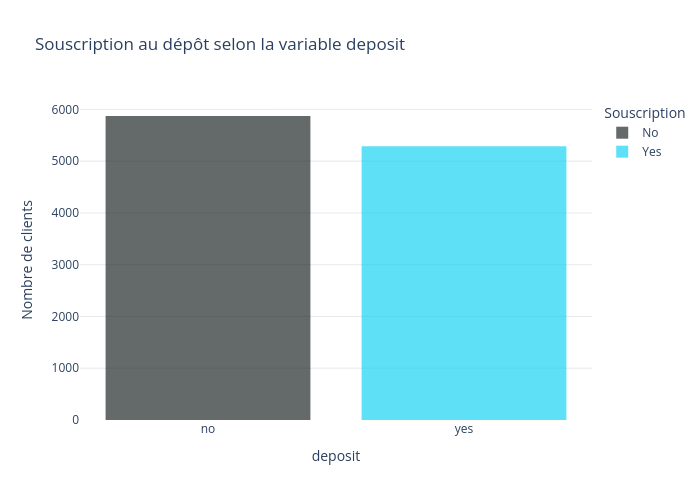

Graphique enregistré sous build/graphs/graph_histo_deposit_deposit.png
Variable cible équilibrée, aucune valeur manquante.

Analyse des variables catégorielles terminée.


In [21]:
analyze_categorical_variables(var_cat, df_bank, build_graphs_path)
df_bank = df_bank.drop("month_numeric", axis=1)

Récapitulatif des informations dont nous disposons sur les différentes variables du dataset :

In [22]:
# Tableau de pertinence
df_pertinence = pd.read_csv(donnees_path / 'tableau_variables.csv', sep = ";", index_col=0, lineterminator="\n")
display(df_pertinence)

,Description,Type info.,Taux de NaN,Distribution des valeurs,Type de variable,Commentaire / Retraitements à réaliser
Nom de la colonne,,,,,,
age,âge du client lors du dépôt,int64,0 %,de 18 à 95 ans avec une concentration entre 32...,quantitative,Distribution cohérente mais très concentrée au...
job,métier pratiqué,object,1 %,['admin.' 'technician' 'services' 'management'...,catégorielle,"70 lignes « unknown », impact dérisoire étant ..."
marital,statut marital,object,0 %,['married' 'single' 'divorced'],catégorielle,NaN
education,niveau d'études,object,4 %,['secondary' 'tertiary' 'primary' 'unknown'],catégorielle,497 lignes « unknown » ;\nContrôle des valeurs...
default,le crédit est-il en défaut ?,object,0 %,['yes' 'no'],catégorielle,Très peu de défauts de crédit dans le dataset
balance,solde bancaire annuel moyen,int64,0 %,de -6847 à 81 204 euros avec une concentration...,quantitative,"Distribution concentrée autour de la médiane, ..."
housing,le client bénéficie-t-il d’un crédit immobilier ?,object,0 %,['yes' 'no'],catégorielle,NaN
loan,le client bénéficie-t-il d’un prêt personnel ?,object,0 %,['yes' 'no'],catégorielle,Très peu de prêts personnels dans le dataset
contact,moyen de contacter le client,object,21 %,['unknown' 'cellular' 'telephone'],catégorielle,Donnée peu pertinente : proportion beaucoup pl...


In [23]:
display(Markdown(txt_conclusion_prepocess))

#### Conclusions sur les variables du dataset

Nous disposons d’ores et déjà de certaines informations nous permettant de cibler nos futurs prospects. Il semblerait que notre prospect idéal soit :
* âgé de moins de 29 ans ou plus de 60 ans,
* célibataire,
* étudiant ou retraité
* issu d'un cursus d’études supérieures
* ayant quelques économies personnelles
* n’ayant aucun crédit en cours
* ayant déjà été contacté lors d’une campagne précédente mais ayant eu lieu il y a moins de 200 jours
* ayant souscrit un produit lors de la campagne précédente.

Nos analyses macro font également ressortir quelques recommandations métier. Les méthodes d’approche à privilégier sont les suivantes :
* contact par appel téléphonique sur une ligne mobile
* avant le 5 du mois ou alors le 10 ou le 30 du mois
* en mars, avril, septembre, octobre ou décembre
* un seul appel par prospect

Pour affiner nos analyses et réussir à prédire si un prospect serait susceptible de souscrire ou non à un dépôt à terme, nous devons passer à l’étape de la modélisation. Néanmoins, avant cela, nous devons procéder aux retraitements suivants :
* job : 1% de valeurs "unknown"(soit 70 lignes), nous avons pris la décision de supprimer ces lignes qui sont peu nombreuses
* education : 4% de valeurs "unknown" (soit 497 lignes), cette variable est importante et ces lignes sont trop nombreuses pour être supprimées. Nous avons donc décidé de compléter les valeurs manquantes. La variable education étant fortement corrélée avec la variable job, nous déduirons les données manquantes du job associé (modalité education la plus fréquente pour le job en question)
* contact : 21% de valeurs "unknown". Après analyse nous avons décidé de supprimer cette colonne qui ne représente pas d'intérêt majeur pour la modélisation.

Pour rappel : la variable poutcome restera inchangée.
En effet, cette variable comporte trop de valeurs manquantes pour pouvoir supprimer des lignes (75% de valeurs "unknown").
De plus, nous avons acté qu'elle était importante pour notre modélisation.
La valeur "unknown" de cette variable constituera donc une valeur à part entière dans notre projet.


### MODELISATION DU PROJET

In [24]:
display(Markdown(txt_classif_choix))

#### Classification du problème

Comme nous l’avons vu précédemment, la variable la plus importante de notre jeu de données est la variable binaire « deposit » qui indique si le prospect a finalement souscrit ou non un dépôt à terme suite à la campagne marketing. Après les différents retraitements opérés lors de la phase de pré-processing, nous disposons de 15 variables explicatives et d’1 variable cible de nature catégorielle.

Nous devons donc mettre en place un modèle d’apprentissage supervisé suivant la technique de la classification (prédiction d’une variable cible de type qualitatif).

Nous avons choisi de nettoyer le dataset avant la modélisation car il y avait peu de données à retraiter et que ces retraitements auront peu d'impact sur la suite de notre projet :
* suppression d'une colonne (contact),
* suppression de seulement 70 lignes pour valeur job manquante,
* et remplacement des 427 valeurs manquantes restantes d'education (70 des valeurs manquantes ayant été supprimées avec la suppression des lignes dont job était manquant).

Le dataset ne présentant pas un grand volume, nous ne réduirons pas sa dimension lors de la modélisation.

Nous diviserons les données en deux parties : étant donné que nous disposons d'un dataset d'un volume correct (plus de 10 000 entrées), 70% du dataset seront dédiés à l’entraînement et 30% du dataset seront dédiés à l’évaluation de notre modèle.

**Choix de la métrique de performance**

Selon la classification de notre projet (modèle supervisé de classification), nous pouvons retenir 4 principales métriques de performance : l’exactitude, la précision, le rappel et le score F1.

* **L'exactitude (accuracy en anglais)** évalue le taux de bonnes prédictions par rapport au nombre total de prédictions. Elle est facile à calculer, facile à interpréter, et résume la performance du modèle avec une valeur unique. Elle évalue mal les performances d’un modèle basé sur des données déséquilibrées, mais ce n'est pas le cas dans notre projet. Cependant, l’exactitude ne permet pas de faire des nuances entre les différentes prédictions et néglige de ce fait le coût des faux négatifs. Notre choix se portera donc sur une métrique plus précise.
* **La précision** est une métrique qui répond à la question : Parmi toutes les prédictions positives du modèle, combien sont de vrais positifs ? Un score de précision élevé nous informe que le modèle ne classe pas aveuglément toutes les observations comme positives. Cette métrique est utile lorsque le coût des faux positifs est élevé.
* **Le rappel (recall en anglais)** est une métrique qui quantifie la proportion d'observations réellement positives qui ont été correctement classifiées positives par le modèle (vrai positifs par rapport à la somme des vrais positifs et faux négatifs). Un score de rappel élevé nous informe que le modèle est capable de bien détecter les observations réellement positives. Cette métrique est utile lorsque le coût des faux négatifs est élevé.
* **Le score F1 (F1-score en anglais)** est une métrique qui permet de combiner la précision et le rappel, puisqu'elle correspond à leur moyenne harmonique.

C'est cette dernière métrique, **le score F1**, qui nous parait la plus adaptée pour évaluer nos différents modèles de Machine Learning.

#### Choix du modèle et optimisation

**Choix de l'encodage**

Notre jeu de données ne comporte plus de valeurs manquantes mais contient encore des données quantitatives extrêmes. Nous avons décidé de les conserver car ces informations ne sont pas aberrantes et restent intéressantes pour notre modèle. Nous ne pouvons pas normaliser ou standardiser les variables concernées car ces techniques sont sensibles aux valeurs extrêmes. Nous devrons en revanche tester s’il est pertinent de les mettre à l’échelle par la technique de Robust Scaling. Les variables concernées sont : age, balance, duration, campaign, pdays, previous.

Les variables catégorielles, quant à elles, devront être encodées de la manière suivante :
* job : OneHotEncoding
* marital : OneHotEncoding
* education : Ordinal Encoding ou OneHotEncoding
* default : OneHotEncoding
* housing : OneHotEncoding
* loan : OneHotEncoding
* day : OneHotEncoding
* month : OneHotEncoding
* poutcome : OneHotEncoding
* deposit : LabelEncoding

**Choix des modèles**

Les modèles que nous avons testé sont les suivants :
* Régression logistique (LogiticRegression)
* Machines à Vecteurs de Support (SVC)
* Méthode des K plus proches voisins (KNN - KNeighborsClassifier)
* Arbres de décision (DecisionTreeClassifier et DecisionTreeRegressor)
* Forêts aléatoires (RandomForestClassifier)
* Gradient Boosting (GradientBoostingClassifier)
* Extreme Gradient Boosting (XGBClassifier)
* CatBoosting (CatBoostClassifier)

**Tests réalisés**

Nous avons testé nos modèles avec différents paramètres :
* avec / sans la variable duration
* avec / sans mise à l'échelle des variables numériques (Robust Scaling)
* avec Ordinal Encoding / OneHotEncoding pour la variable education
* avec / sans optimisation des hyperparamètres

**Construction des modèles**

Nous avons tenté de faire ressortir les variables les plus importantes utilisées par nos différents modèles pour décider du sort de la variable duration. Cependant, nous avons été confrontés à une limite : Les modèles KNN et SVM ne disposent pas de l'attribut feature_importances_ ou coef_. Etant donné qu’il ne s’agit pas des modèles les plus performants et que la grande majorité des modèles dispose de ces attributs, nous avons basé nos analyses sur les résultats disponibles en faisant abstraction des éléments manquants.

**Optimisation des hyperparamètres**

Pour optimiser les hyperparamètres, nous avons fait appel à la méthode GridSearch : celle-ci explore toutes les combinaisons possibles d'hyperparamètres spécifiés pour trouver les meilleurs réglages du modèle.

Nous avons également testé RandomizedSearch et BayerSearch, mais sans résultats probants, bien au contraire. Malgré des tests très longs sur ces hyperparamètres extrêmement lourds à faire tourner même en local, les résultats se trouvaient être moins bons qu'avec GridSearch. Nous avons donc décidé de ne pas intégrer ces tests à notre rapport.

Nous avons testé l'optimisation des hyperparamètres sur la quasi-totalité des modèles sélectionnés. Ces tests ont été réalisés en local car ils sont relativement lourds selon les modèles. Pour éviter de surcharger la plateforme Streamlit et ainsi perdre en efficacité, nous ne présenterons l'optimisation des paramètres que pour les 3 modèles qui nous semblent être les plus performants, à savoir : CatBoosting, Extreme Gradient Boosting et Forêts aléatoires.

**Optimisation du chargement des modèles entraînés**

Enfin, dans le but d'optimiser encore davantage la rapidité de notre plateforme Steamlit, nous avons utilisé le module Pickle. Il s’agit d’une bibliothèque standard de Python qui permet de sérialiser et désérialiser des objets. Elle permet de convertir des objets Python en un format binaire qui peut être enregistré sur le disque et récupéré ultérieurement, ce qui en fait un outil extrêmement utile pour la sauvegarde et la restauration de modèles de machine learning. 

Concrètement, nous avons entraîné en local chacun de nos modèles, l’un après l’autre, en modifiant les paramètres selon nos différents angles d’étude. Pour chaque test réalisé, le module pickle nous a permis de sauvegarder le modèle entraîné ainsi que les meilleurs hyperparamètres utilisés le cas échéant. Seuls ces fichiers sont chargés dans Streamlit, les différents modèles n’ont pas à être réentrainés pour visualiser les résultats de nos tests. Notre plateforme est ainsi plus réactive et plus efficace dans la livraison des résultats des tests.

**Interprétabilité des modèles**

Concernant l’interprétabilité de nos 3 modèles les plus performants (CatBoost, Random Forest, Extreme Gradient Boost), nous avons pris le parti de la mesurer avec SHAP (Shapley Additive exPlanations). Cette méthode attribue une valeur à chaque variable utilisée par un modèle donné de machine learning, mesurant son impact sur la prédiction ﬁnale. L’avantage de SHAP est qu’il considère l’ensemble des combinaisons de caractéristiques possibles pour en évaluer leur impact moyen, garantissant ainsi une interprétation équitable.

Après avoir préparé les données, nous avons réduit l’échantillon d’observations analysées par SHAP à 1 000 aﬁn de limiter son calcul, bien trop lourd sans cette limitation.

SHAP nous a permis de :
* Conﬁrmer l’importance extrême de la variable duration sur CatBoost (3.75 fois plus importante que la seconde valeur).
* Corriger la place de duration sur XGBoost, là où la feature_importance ne la faisait apparaître qu’en 4ème position, 3.75 fois moins importante qu’une autre variable (alors qu’avec SHAP elle
est 3.9 fois plus importante).


In [25]:
# Génération des diffèrents DF retraités


# RETRAITEMENTS POUR GENERER df_bank_1 (retraitements minimalistes)

# Suppression des lignes dont la valeur "job" est manquante :
df_bank_1 = df_bank.loc[df_bank["job"] != "unknown"]

# Remplacement des unknown de "education" par la modalité la plus fréquente rencontrée pour un "job" identique :
df_bank_1.loc[df_bank_1["education"] == "unknown", "education"] = df_bank_1.loc[df_bank_1["education"] == "unknown", "job"].map(jobs_education)		

print("Valeurs prises par la variable job après retraitement :\n", df_bank_1["job"].value_counts())
print(separation)

print("Valeurs prises par la variable education après retraitement :\n", df_bank_1["education"].value_counts())
print(separation)

# Suppression de la colonne "contact" :
df_bank_1 = df_bank_1.drop("contact", axis=1)

print("Apercu de la structure du dataframe df_bank_1 après retraitements :")
print(df_bank_1.info())

# Export du dataframe df_bank_1 en fichier .csv
df_bank_1.to_csv(build_df_path / 'bank_1.csv', index=False, sep=',')


# RETRAITEMENTS SUPPLEMENTAIRES POUR GENERER df_bank_2 (sans duration)

# Suppression de la colonne "duration" :
df_bank_2 = df_bank_1.drop("duration", axis=1)

# Export du dataframe df_bank_2 en fichier .csv
df_bank_2.to_csv(build_df_path / 'bank_2.csv', index=False, sep=',')

print("Apercu de la structure du dataframe df_bank_2 après retraitements :")
print(df_bank_2.info())

Valeurs prises par la variable job après retraitement :
 job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64
--------------------------------------------------------------------------------
Valeurs prises par la variable education après retraitement :
 education
secondary    5815
tertiary     3775
primary      1502
Name: count, dtype: int64
--------------------------------------------------------------------------------
Apercu de la structure du dataframe df_bank_1 après retraitements :
<class 'pandas.core.frame.DataFrame'>
Index: 11092 entries, 0 to 11161
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        11092 non-null  int64   
 1   job        11092 non-null  object  
 2   marital    1109

### MACHINE LEARNING

In [26]:
# Mise en place du tronc commun à tous nos tests de machine learning

le = LabelEncoder()
ohe = OneHotEncoder(drop = "first")
oe = OrdinalEncoder(categories = [["primary", "secondary", "tertiary"]])
num_scaler = RobustScaler()

models = {
        "CatBoost" : CatBoostClassifier(silent = True),  # 'silent=True' pour éviter les logs
        "Random Forest": RandomForestClassifier(),
        "Extreme Gradient Boost" : XGBClassifier(),
        "Gradient Boost" : GradientBoostingClassifier(),
        "Logistic Regression": LogisticRegression(max_iter = 1000),
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "SVM": SVC(),
        "KNN" : neighbors.KNeighborsClassifier()
        }

# Définition des hyperparamètres à tester pour chaque modèle
param_grid = {
            'Random Forest': {
                            'n_estimators': [50, 100, 200],
                            'max_depth': [None, 5, 10, 20],
                            'min_samples_split': [2, 5, 10]
                            },
            'Extreme Gradient Boost': {
                            'n_estimators': [100, 200, 300],
                            'learning_rate': [0.01, 0.1, 0.2],
                            'max_depth': [3, 5, 7]
                            },
            'CatBoost': {
                            'iterations': [100, 200, 300],
                            'learning_rate': [0.01, 0.1, 0.2],
                            'depth': [6, 8, 10]
                            }
            }

#### Choisissez le test à lancer :

Modèle testé : CatBoost
Variables les plus importantes du modèle CatBoost


,Variables,Importance
2,numerical__duration,28.980767
0,numerical__age,6.379116
1,numerical__balance,6.214600
65,categorical_ohe__poutcome_success,5.301930
60,categorical_ohe__month_may,5.179247


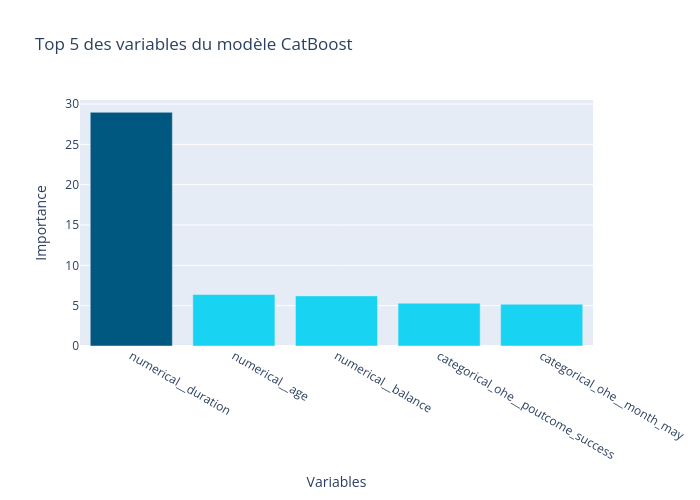

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_CatBoost.png
Calcul des valeurs SHAP pour le modèle CatBoost...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Dimensions des shap_values avant transformation : (1000, 67)
Dimensions des shap_values après transformation : (1000, 67)


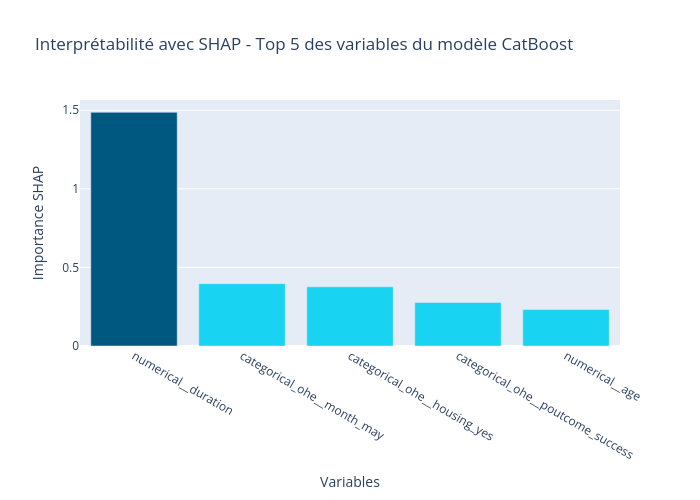

Graphique enregistré sous build/graphs/test8/plot_shap/graph_shap_CatBoost.png
--------------------------------------------------------------------------------
Modèle testé : Random Forest
Variables les plus importantes du modèle Random Forest


,Variables,Importance
2,numerical__duration,0.323136
1,numerical__balance,0.081801
0,numerical__age,0.079673
65,categorical_ohe__poutcome_success,0.041300
3,numerical__campaign,0.035570


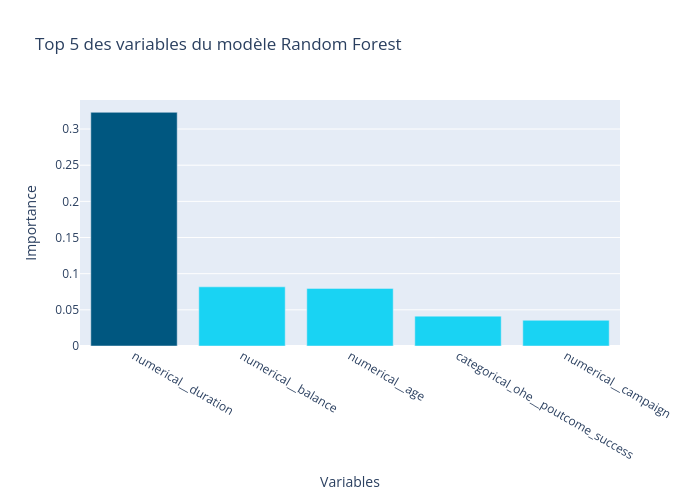

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_Random Forest.png
Calcul des valeurs SHAP pour le modèle Random Forest...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Dimensions des shap_values avant transformation : (1000, 67, 2)
Dimensions des shap_values après transformation : (1000, 67)


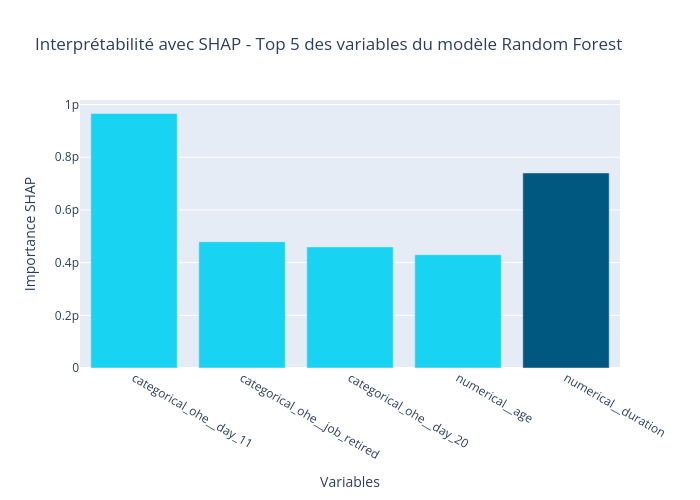

Graphique enregistré sous build/graphs/test8/plot_shap/graph_shap_Random Forest.png
--------------------------------------------------------------------------------
Modèle testé : Extreme Gradient Boost
Variables les plus importantes du modèle Extreme Gradient Boost


,Variables,Importance
65,categorical_ohe__poutcome_success,0.211951
59,categorical_ohe__month_mar,0.061032
21,categorical_ohe__housing_yes,0.042410
2,numerical__duration,0.036928
62,categorical_ohe__month_oct,0.035974


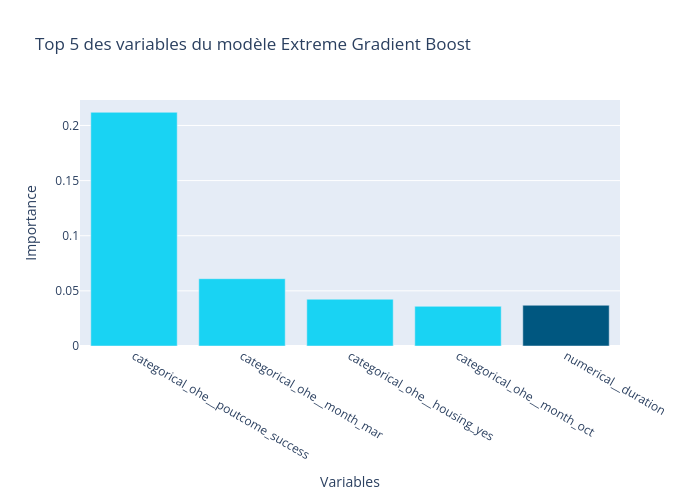

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_Extreme Gradient Boost.png
Calcul des valeurs SHAP pour le modèle Extreme Gradient Boost...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Dimensions des shap_values avant transformation : (1000, 67)
Dimensions des shap_values après transformation : (1000, 67)


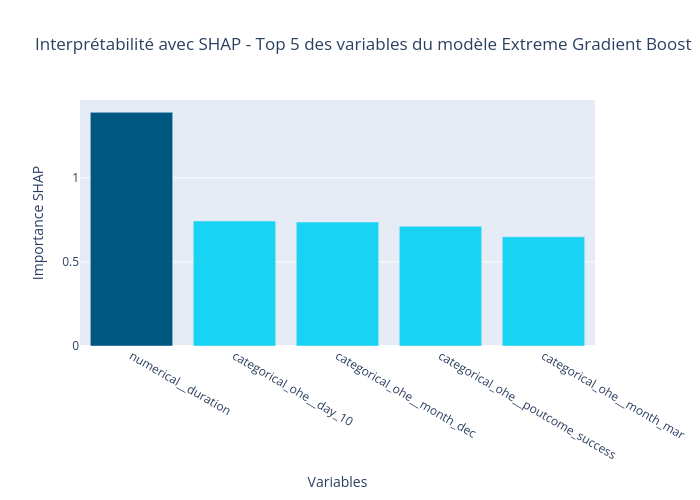

Graphique enregistré sous build/graphs/test8/plot_shap/graph_shap_Extreme Gradient Boost.png
--------------------------------------------------------------------------------
Modèle testé : Gradient Boost
Variables les plus importantes du modèle Gradient Boost


,Variables,Importance
2,numerical__duration,0.543126
65,categorical_ohe__poutcome_success,0.126657
21,categorical_ohe__housing_yes,0.067046
4,numerical__pdays,0.046088
0,numerical__age,0.036120


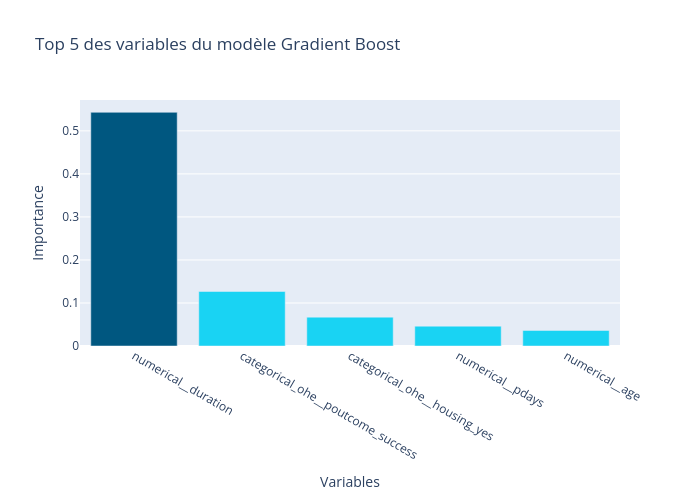

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_Gradient Boost.png
Calcul des valeurs SHAP pour le modèle Gradient Boost...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Dimensions des shap_values avant transformation : (1000, 67)
Dimensions des shap_values après transformation : (1000, 67)


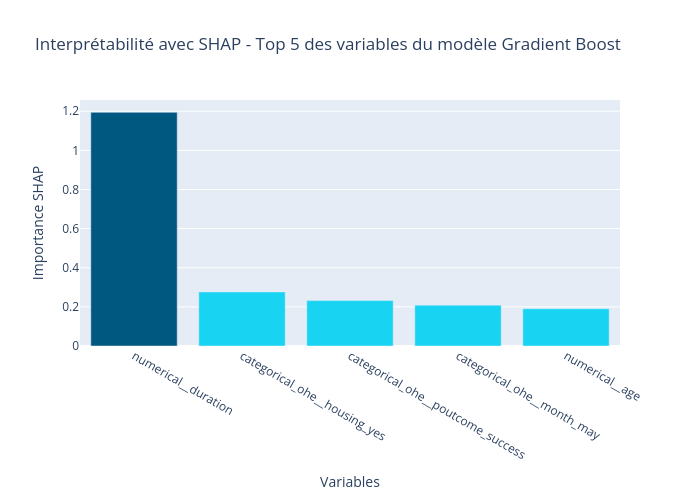

Graphique enregistré sous build/graphs/test8/plot_shap/graph_shap_Gradient Boost.png
--------------------------------------------------------------------------------
Modèle testé : Logistic Regression
Variables les plus importantes du modèle Logistic Regression


,Variables,Coefficient,Importance
65,categorical_ohe__poutcome_success,1.940259,1.940259
2,numerical__duration,1.934153,1.934153
59,categorical_ohe__month_mar,1.622840,1.622840
60,categorical_ohe__month_may,-1.399700,1.399700
56,categorical_ohe__month_jan,-1.359128,1.359128


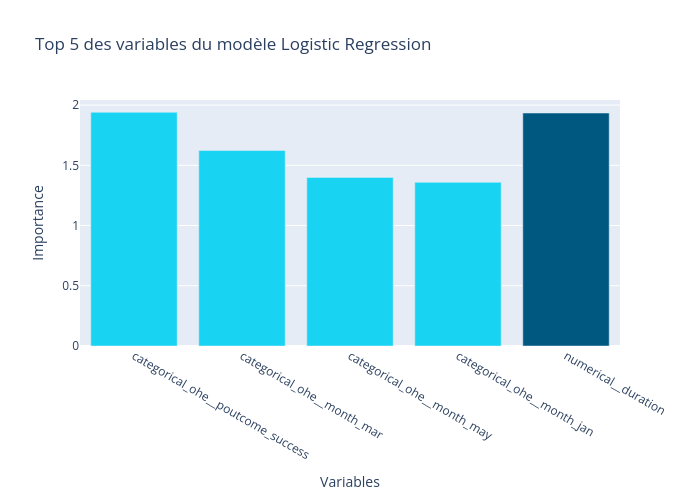

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_Logistic Regression.png
Calcul des valeurs SHAP pour le modèle Logistic Regression...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Erreur lors du calcul des valeurs SHAP pour le modèle Logistic Regression: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>
--------------------------------------------------------------------------------
Modèle testé : Decision Tree Classifier
Variables les plus importantes du modèle Decision Tree Classifier


,Variables,Importance
2,numerical__duration,0.325618
65,categorical_ohe__poutcome_success,0.102146
1,numerical__balance,0.092613
0,numerical__age,0.079413
21,categorical_ohe__housing_yes,0.045600


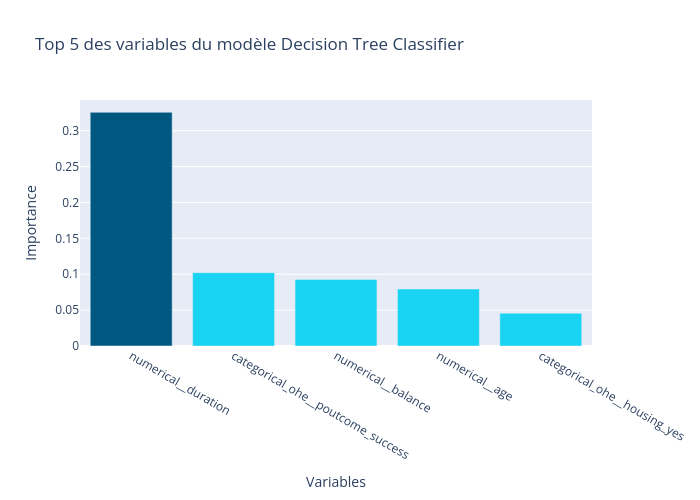

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_Decision Tree Classifier.png
Calcul des valeurs SHAP pour le modèle Decision Tree Classifier...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Dimensions des shap_values avant transformation : (1000, 67, 2)
Dimensions des shap_values après transformation : (1000, 67)


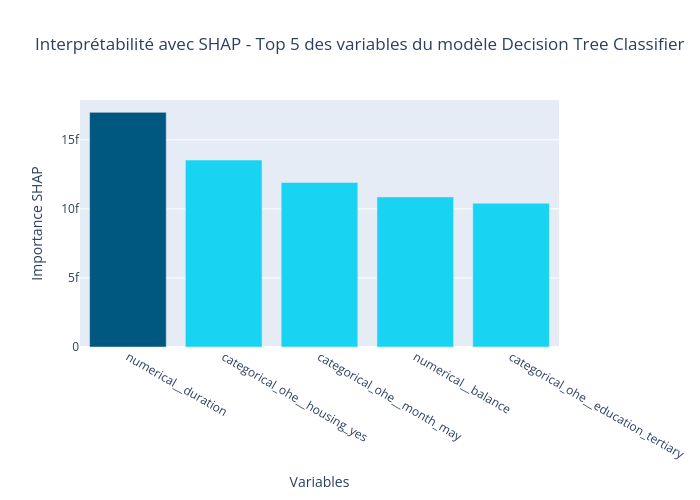

Graphique enregistré sous build/graphs/test8/plot_shap/graph_shap_Decision Tree Classifier.png
--------------------------------------------------------------------------------
Modèle testé : Decision Tree Regressor
Variables les plus importantes du modèle Decision Tree Regressor


,Variables,Importance
2,numerical__duration,0.325288
65,categorical_ohe__poutcome_success,0.101543
1,numerical__balance,0.087434
0,numerical__age,0.080717
21,categorical_ohe__housing_yes,0.045600


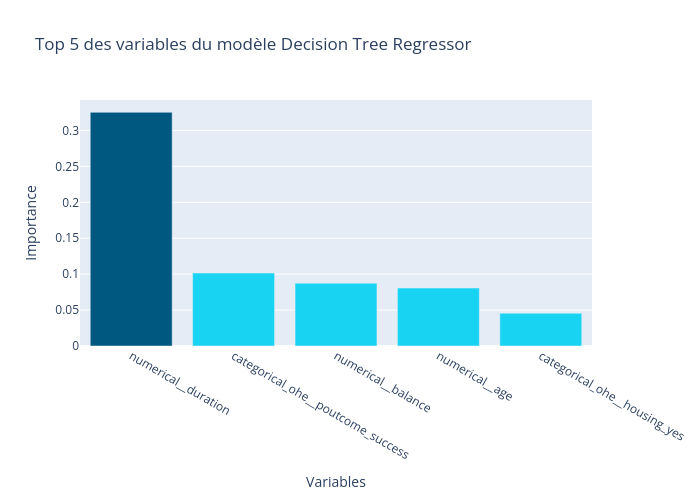

Graphique enregistré sous build/graphs/test8/plot_var_imp/graph_var_imp_Decision Tree Regressor.png
Calcul des valeurs SHAP pour le modèle Decision Tree Regressor...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Dimensions des shap_values avant transformation : (1000, 67)
Dimensions des shap_values après transformation : (1000, 67)


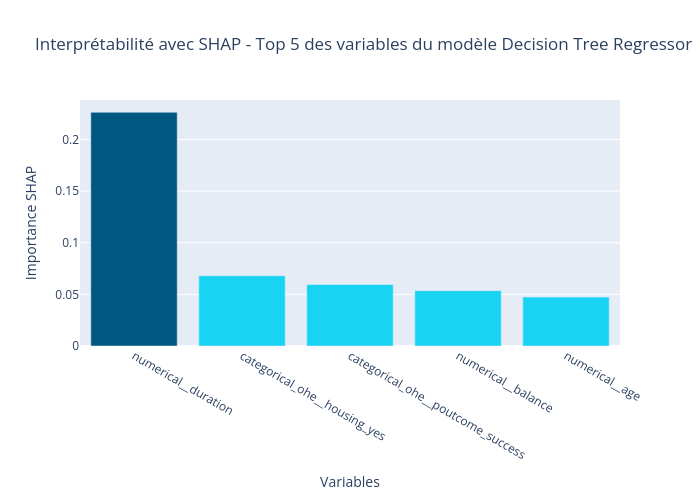

Graphique enregistré sous build/graphs/test8/plot_shap/graph_shap_Decision Tree Regressor.png
--------------------------------------------------------------------------------
Modèle testé : SVM
Variables les plus importantes du modèle SVM
Ce modèle ne possède pas d'attribut feature_importances_ ou coef_
Calcul des valeurs SHAP pour le modèle SVM...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Erreur lors du calcul des valeurs SHAP pour le modèle SVM: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'>
--------------------------------------------------------------------------------
Modèle testé : KNN
Variables les plus importantes du modèle KNN
Ce modèle ne possède pas d'attribut feature_importances_ ou coef_
Calcul des valeurs SHAP pour le modèle KNN...
Dimensions initiales des données : (3328, 67)
Calcul des valeurs SHAP pour 3328 exemples...
Erreur lors du calcul des valeurs SHAP pour le modèle KNN: Model ty

,Modèle,Précision,Rappel,Score F1
0,CatBoost,0.831605,0.863752,0.847373
1,Random Forest,0.815085,0.849176,0.831782
2,Extreme Gradient Boost,0.822482,0.848542,0.835309
3,Gradient Boost,0.824606,0.828264,0.826431
4,Logistic Regression,0.826174,0.780101,0.802477
5,Decision Tree Classifier,0.766887,0.733840,0.750000
6,Decision Tree Regressor,0.762155,0.735108,0.748387
7,SVM,0.809319,0.836502,0.822686
8,KNN,0.791610,0.741445,0.765707


In [27]:
# CONFIGURATION DES PARAMETRES
configurations = {
    1: {"duration": "avec", "robustscaling": "sans", "education": "oe", "hyperparam": "sans"},
    2: {"duration": "avec", "robustscaling": "avec", "education": "oe", "hyperparam": "sans"},
    3: {"duration": "sans", "robustscaling": "sans", "education": "oe", "hyperparam": "sans"},
    4: {"duration": "sans", "robustscaling": "avec", "education": "oe", "hyperparam": "sans"},
    5: {"duration": "sans", "robustscaling": "avec", "education": "ohe", "hyperparam": "sans"},
    6: {"duration": "sans", "robustscaling": "avec", "education": "oe", "hyperparam": "avec"},
    7: {"duration": "avec", "robustscaling": "sans", "education": "ohe", "hyperparam": "sans"},
    8: {"duration": "avec", "robustscaling": "avec", "education": "ohe", "hyperparam": "sans"},
    9: {"duration": "avec", "robustscaling": "sans", "education": "oe", "hyperparam": "avec"},
    10: {"duration": "avec", "robustscaling": "avec", "education": "oe", "hyperparam": "avec"},
    11: {"duration": "avec", "robustscaling": "sans", "education": "ohe", "hyperparam": "avec"},
    12: {"duration": "sans", "robustscaling": "avec", "education": "ohe", "hyperparam": "avec"},
    13: {"duration": "sans", "robustscaling": "sans", "education": "oe", "hyperparam": "avec"},
    14: {"duration": "sans", "robustscaling": "sans", "education": "ohe", "hyperparam": "sans"},
    15: {"duration": "sans", "robustscaling": "sans", "education": "ohe", "hyperparam": "avec"},
    16: {"duration": "avec", "robustscaling": "avec", "education": "ohe", "hyperparam": "avec"},
    }

# Récupération de la configuration
num_test = os.getenv("GENERATE_ML_TEST")
if num_test is None:
    num_test = input("Entrez le numéro de test : ")
num_test = int(num_test)

if num_test in configurations:
    config = configurations[num_test]
    duration = config["duration"]
    robustscaling = config["robustscaling"]
    education = config["education"]
    hyperparam = config["hyperparam"]
else:
    print("Veuillez sélectionner un numéro de test valide !")

test_path = build_ml_path / f"test{num_test}" 
test_path.mkdir(exist_ok=True)

if duration == "avec":
    df = df_bank_1
    var_num = ["age","balance","duration","campaign","pdays","previous"]
else:
    df = df_bank_2
    var_num = ["age","balance","campaign","pdays","previous"]

data = df.drop("deposit", axis = 1)
target = df["deposit"]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.30, random_state = 88)
if robustscaling == "avec":
    if education == "oe":
        var_cat_for_ohe = ["job","marital","default","housing","loan","day","month","poutcome"]
        prepro = ColumnTransformer(transformers = [("numerical", num_scaler, var_num), ("categorical_ohe", ohe, var_cat_for_ohe), ("categorical_oe", oe, ["education"])])
    else:
        var_cat_for_ohe = ["job","marital", "education","default","housing","loan","day","month","poutcome"]
        prepro = ColumnTransformer(transformers = [("numerical", num_scaler, var_num), ("categorical_ohe", ohe, var_cat_for_ohe)])
else :
    if education == "oe":
        var_cat_for_ohe = ["job","marital","default","housing","loan","day","month","poutcome"]
        prepro = ColumnTransformer(transformers = [("numerical", "passthrough", var_num),("categorical_ohe", ohe, var_cat_for_ohe), ("categorical_oe", oe, ["education"])])
    else : 
        var_cat_for_ohe = ["job","marital", "education","default","housing","loan","day","month","poutcome"]
        prepro = ColumnTransformer(transformers = [("numerical", "passthrough", var_num),("categorical_ohe", ohe, var_cat_for_ohe)])
X_train_prepro = prepro.fit_transform(X_train)
X_test_prepro = prepro.transform(X_test)
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
resultats = []
features = {}
best_params_list = {}
for model_name, model in models.items():
    print("Modèle testé : " + model_name)
    model_file = test_path / f"ml_test{num_test}_{model_name}_model.pkl"
    params_file = test_path / f"ml_test{num_test}_{model_name}_best_params.pkl"
    if model_file.exists():
        with open(model_file, "rb") as f:
            model = pickle.load(f)
        y_pred_train = model.predict(X_train_prepro)
        y_pred_test = model.predict(X_test_prepro)
    else:
        if hyperparam == "avec":
            if params_file.exists():
                with open(params_file, "rb") as f:
                    best_params = pickle.load(f)
                best_params_list[model_name] = best_params
            else:
                if model_name in param_grid:  # Si des paramètres sont spécifiés pour ce modèle
                    grid_search = GridSearchCV(estimator=model, param_grid = param_grid[model_name], scoring='f1', cv=5, n_jobs=-1)
                    grid_search.fit(X_train_prepro, y_train)
                    model = grid_search.best_estimator_  # Utiliser les meilleurs paramètres pour le modèle
                    best_params_list[model_name] = grid_search.best_params_  # Sauvegarder les meilleurs paramètres
                    y_pred_train = grid_search.predict(X_train_prepro)
                    y_pred_test = grid_search.predict(X_test_prepro)
                    print("Meilleurs hyperparamètres pour le modèle ", model_name)
                    print(grid_search.best_params_)
                    with open(params_file, "wb") as f:
                        pickle.dump(best_params_list[model_name], f)
                else:
                    print("Aucun hyperparamètre n'a été optimisé pour ce test.")
                    model.fit(X_train_prepro, y_train)
                    y_pred_train = model.predict(X_train_prepro)
                    y_pred_test = model.predict(X_test_prepro)
        else:
            model.fit(X_train_prepro, y_train)
            y_pred_train = model.predict(X_train_prepro)
            y_pred_test = model.predict(X_test_prepro)
        with open(model_file, "wb") as f:
            pickle.dump(model, f)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    resultats.append({
        "Modèle": model_name,
        "Précision": precision,
        "Rappel": recall,
        "Score F1": f1
        })
    print("Variables les plus importantes du modèle", model_name)
    nom_var = prepro.get_feature_names_out()
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        data_importances = pd.DataFrame({"Variables" : nom_var, "Importance" : importance}).sort_values(by = "Variables", ascending = False)
        top_data_importances = pd.DataFrame({"Variables" : nom_var, "Importance" : importance}).sort_values(by = "Importance", ascending = False)
        display(top_data_importances.head(5))
        top_data_importances["Color"] = top_data_importances["Variables"].apply(lambda x: "deep_blue" if x == "numerical__duration" else "light_blue")
        fig = px.bar(top_data_importances.head(5), x="Variables", y="Importance", color="Color", color_discrete_map={"deep_blue": "#005780", "light_blue": "#19D3F3"}, title="Top 5 des variables du modèle " + model_name)
        fig.update_layout(showlegend=False)
        test_graphs_folder = Path(build_graphs_path / f"test{num_test}" / "plot_var_imp")
        test_graphs_folder.mkdir(parents=True, exist_ok=True)
        full_path = Path(test_graphs_folder / f"graph_var_imp_{model_name}.png")
        fig.write_image(full_path)
        display(Image(filename=full_path))
        print("Graphique enregistré sous", full_path)
        for feature, importance in zip(nom_var, importance):
            if feature not in features:
                features[feature] = {}
            features[feature][model_name] = importance
    elif hasattr(model, "coef_"):
        coef = model.coef_
        if coef.ndim == 1:  # Si c'est un tableau 1D (ce qui arrive parfois en classification binaire)
            coef = coef.reshape(1, -1)
        coef = coef[0]
        data_importances = pd.DataFrame({"Variables": nom_var, "Coefficient": coef})
        data_importances["Importance"] = data_importances["Coefficient"].abs()
        data_importances = data_importances.sort_values(by = "Variables", ascending = False)
        top_data_importances = data_importances.sort_values(by = "Importance", ascending = False)
        display(top_data_importances.head(5))
        top_data_importances["Color"] = top_data_importances["Variables"].apply(lambda x: "deep_blue" if x == "numerical__duration" else "light_blue")
        fig = px.bar(top_data_importances.head(5), x="Variables", y="Importance", color="Color", color_discrete_map={"deep_blue": "#005780", "light_blue": "#19D3F3"}, title="Top 5 des variables du modèle " + model_name)
        fig.update_layout(showlegend=False)
        test_graphs_folder = Path(build_graphs_path / f"test{num_test}" / "plot_var_imp")
        test_graphs_folder.mkdir(parents=True, exist_ok=True)
        full_path = Path(test_graphs_folder / f"graph_var_imp_{model_name}.png")
        fig.write_image(full_path)
        display(Image(filename=full_path))
        print("Graphique enregistré sous", full_path)
        for feature, importance in zip(nom_var, data_importances["Importance"]):
            if feature not in features:
                features[feature] = {}
            features[feature][model_name] = importance
    else:
        print("Ce modèle ne possède pas d'attribut feature_importances_ ou coef_")
    # Interprétabilité avec SHAP
    plot_shap_values_from_pickles(build_ml_path, num_test, X_test_prepro, prepro, build_graphs_path)
print("Récapitulatif des meilleurs hyperparamètres")
if hyperparam == "avec":
    for model_name, params in best_params_list.items():
        print(f"{model_name}: {params}")
else:
    print("Aucun hyperparamètre n'a été optimisé pour ces tests.")
print(separation)
recap_resultats = pd.DataFrame(resultats)
print("Récapitulatif des performances des différents modèles")
print("(selon les paramètres choisis précédemment)")
display(recap_resultats)
# print("Importances des variables pour chacun des modèles")
# print("(selon les paramètres choisis précédemment)")
# recap_importances = pd.DataFrame(features).T  # Transposition pour avoir les variables en ligne
# display(recap_importances)

In [28]:
display(Markdown(txt_interpretation))

#### Interprétation des résultats

La variable duration est restée au centre des débats durant tout le projet :
* Elle prend une place prépondérante dans l’ensemble des analyses.
* Toutefois elle n’est connue qu’à posteriori, ce qui interroge sur son utilisabilité en amont.

En effet, pour les modèles pouvant être analysés grâce à leur attribut feature_importances_ ou coef_, la variable duration se trouve dans le top 5 de 6 d’entre-eux. Son importance dans la qualité des prédictions de machine learning n’est donc pas discutable ; les résultats sont globalement supérieurs de 10 points lorsqu’elle est intégrée aux calculs. Toutefois, le temps d’appel, à savoir son essence même, ne peut effectivement pas être connu avant d’avoir passé cet appel.

Devant ce dilemme, nous avons pris la décision d’articuler notre analyse autour de ces deux possibilités, pour ne pas décider arbitrairement d’occulter une face importante de notre étude. Ainsi, tous nos modèles de machine learning sont disponibles en conservant ou non la variable duration. Cela nous permet d'optimiser ou non les scores du machine learning selon notre objectif du moment, tout en conservant des données les plus réalistes possibles selon les besoins. 
Toutefois, pour obtenir un résultat optimal lors de l’application de nos modèles, le métier devra rester conscient du fait que le temps d’appel est une caractéristique à prendre en compte pour améliorer l’efficience du process.

La mise à l'échelle par RobustScaling agit positivement sur les modèles KNN et SVM. Elle est cependant sans incidence significative pour les autres modèles.

Le fait d’encoder la variable education en Ordinal Encoding ou OneHotEncoding semble peu importer. Les résultats sont équivalents avec les 2 méthodes.

L’utilisation d’hyperparamètres ne semble pas avoir d’impact sur nos modèles.

Nous pouvons conclure de tous nos essais que les modèles de base sont très bien optimisés pour l'utilisation dans notre dataset.

Le modèle plus performant est celui du **CatBoosting** utilisé en suivant les paramètres ci-après : 
* avec duration
* RobustScaling sur les variables numériques
* OneHotEncoding pour l'encodage de la variable duration
* sans optimisation des hyperparamètres

C’est donc ce modèle CatBoost qui servira à la conception de notre outil de prédiction. La durée de l’appel représente une importance non négligeable dans le modèle, mais étant donné sa potentielle indisponibilité, il nous parait utile de prévoir deux options. Ainsi, notre outil proposera de renseigner cette donnée en vue de la prédiction, mais permettra également d’obtenir un résultat dans le cas où elle serait absente.


In [29]:
# Concrétisation d'une prédiction
# Options : avec ou sans duration
# Les autres paramètres sont figés de la manière suivante :
# avec Robust Scaling / OneHotEncoding pour education / sans optimisation des hyperparamètres 
# > test 8 (avec duration) et test 5 (sans duration) 

# POUR RAPPEL
# configurations = {
    # 5: {"duration": "sans", "robustscaling": "avec", "education": "ohe", "hyperparam": "sans"},
    # 8: {"duration": "avec", "robustscaling": "avec", "education": "ohe", "hyperparam": "sans"}
    # }

# Exemple de profil test
criteres_pred = {"age" : [25],                  #saisir l'age en chiffres
                 "marital" : ["single"],        #saisir le statut marital ("single", "married", "divorced")
                 "job" : ["student"],           #saisir le métier ("admin.", "technician", "services", "management", "blue-collar", "retired", "student", "unemployed", "entrepreneur", "housemaid", "self-employed")
                 "education" : ["tertiary"],    #saisir le niveau d'études ("primary", "secondary", "tertiary")
                 "default" : ["no"],            #en défaut de paiement ? saisir "yes" ou "no"
                 "balance" : [35000],           #saisir le solde bancaire (nombre entier)
                 "housing" : ["no"],            #crédit immobilier en cours ? saisir "yes" ou "no"
                 "loan" : ["no"],               #crédit à la consommation en cours ? saisir "yes" ou "no"
                 "day" : [13],                  #date prévue du prochain contact : saisir le jour en chiffre
                 "month" : ["dec"],             #date prévue du prochain contact : saisir le mois sur 3 positions ("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec")
                 "duration" : ["unknown"],      #durée pévue du contact téléphonique en secondes : saisir un nombre entier ou "unknown" si non connu
                 "campaign" : [4],              #nombre de fois où le prospect a été contacté pour cette campagne (y compris le contact prévu prochainement) : saisir un nombre entier
                 "pdays" : [30],                #nombre de jours écoulés depuis le dernier contact pour la campagne précédente : saisir un nombre entier ou -1 si jamais contacté
                 "previous" : [2],              #nombre de fois où le prospect a été contacté pour la compagne précédente : saisir un nombre entier ou "unknown" si jamais contacté
                 "poutcome" : ["success"]       #saisir le résultat de la campagne précédente ("failure", "success", "other")
                }

df_pred = pd.DataFrame(data = criteres_pred)

model_name = "CatBoost"
if df_pred["duration"][0] == "unknown":
    num_test = 5
    df = df_bank_2
    df_pred = df_pred.drop("duration", axis=1)
    var_num = ["age","balance","campaign","pdays","previous"]
else:
    num_test = 8
    df = df_bank_1
    var_num = ["age","balance","duration","campaign","pdays","previous"]
var_cat_for_ohe = ["job","marital", "education","default","housing","loan","day","month","poutcome"]
data = df.drop("deposit", axis = 1)
target = df["deposit"]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.30, random_state = 88)
prepro = ColumnTransformer(transformers = [("numerical", num_scaler, var_num), ("categorical_ohe", ohe, var_cat_for_ohe)])
X_train_prepro = prepro.fit_transform(X_train)
y_train = le.fit_transform(y_train)

df_pred_prepro = prepro.transform(df_pred)

test_path = build_ml_path / f"test{num_test}" 
model_file = test_path / f"ml_test{num_test}_{model_name}_model.pkl"
with open(model_file, "rb") as f:
    model = pickle.load(f)

# Prédiction
y_pred = model.predict(df_pred_prepro)
y_pred_proba = model.predict_proba(df_pred_prepro)[:,1]
y_pred_proba_pourcentage = round(y_pred_proba[0]*100, 1)

# Affichage des résultats
print("Ce prospect est-il susceptible de souscrire un dépôt à terme lors de cette campagne ?")
if y_pred[0] == 1:
    if y_pred_proba_pourcentage > 70:
        print("Oui, ce prospect présente une probabilité de ", y_pred_proba_pourcentage,"% de souscrire un dépôt à terme.")
    else:
        print("Oui, mais attention, ce prospect ne présente qu'une probabilité de ", y_pred_proba_pourcentage,"% de souscrire un dépôt à terme.")
else:
    print("Non, ce prospect ne présente qu'une probabilité de ", y_pred_proba_pourcentage,"% de souscrire un dépôt à terme.")

Ce prospect est-il susceptible de souscrire un dépôt à terme lors de cette campagne ?
Oui, ce prospect présente une probabilité de  98.0 % de souscrire un dépôt à terme.


### CONCLUSION DU PROJET

In [30]:
display(Markdown(txt_conclusion_generale))

Notre projet Bank Marketing nous a permis de mettre en pratique la puissance du machine learning et de l’analyse de données dans la résolution d’enjeux stratégiques tel que l’optimisation d’une campagne marketing.
Après avoir identifié un profil type de prospect le plus enclin à souscrire, entraîné un algorithme de prédiction de souscription global, et créé un outil de prédiction individuelle, il reste encore de nombreuses étapes métier à mettre en œuvre.

#### Recommandations métier

Pour capitaliser sur les résultats de notre projet, divers axes peuvent être approfondis :
1. Formation interne : Former les équipes marketing et décisionnelles à l’utilisation de l’outil Streamlit et à l’interprétation des résultats. Cette étape est essentielle pour garantir la pérennité des outils créés et les exploiter pleinement.
1. Automatisation des processus : Mettre en place un système automatisé de suivi des campagnes via des tableaux de bord interactifs. Ce type d’outil offrirait une visibilité instantanée sur les performances, permettant des ajustements rapides en fonction des retours des équipes d’exploitation.
1. Optimisation des interactions client : Des actions pourront être mises en place en fonction des prédictions du modèle, telles que le contact ou le rappel par mail ou SMS pour encourager la souscription, ou un démarchage différencié selon le type de client et le produit à placer.
1. Prévision des flux financiers : En anticipant le nombre de souscription de clients, et donc le versement des fonds, la banque pourra gérer différemment ses besoins ou ses excédents de trésorerie à un moment donné, et donc optimiser ses placements ou ses investissements.

#### Perspectives d’évolution des outils

Plusieurs améliorations techniques et méthodologiques pourront être envisagées pour développer l’efficacité de ces premiers outils :
1. Ciblage dynamique : Intégrer directement le modèle dans les outils de gestion CRM pour un ciblage en temps réel des prospects les plus prometteurs. Cela permettrait de rationaliser les efforts marketing et d’allouer les ressources de manière plus efficiente.
1. Développement des produits : Il faudra s’interroger avec les équipes marketing sur les raisons de non-souscription automatique de nombreux clients, et potentiellement développer des produits financiers susceptibles de convertir leur refus en souscription.
1. Amélioration continue du modèle : Réentraînement périodique avec des données actualisées pour capturer les évolutions comportementales des prospects et s’adapter aux évolutions du marché.
1. Enrichissement des données : Intégration de nouvelles sources de données, telles que des questionnaires clients ou les retours des campagnes précédentes, pour affiner davantage les modèles prédictifs.
1. Simulations anticipées : Développer des fonctionnalités de simulation permettant de tester différents scénarios de campagne avant leur lancement. Par exemple, analyser la réussite potentielle d’une nouvelle offre ou de nouvelles stratégies de contact.

#### Vision à long terme

Au-delà de ce projet, l’intégration de décisions data-driven dans la stratégie marketing de l’entreprise représente un élément crucial pour renforcer son eﬃcacité et sa compétitivité.

Ce projet constitue une démonstration des bénéﬁces que peut apporter une démarche prédictive, et son intégration au cœur du métier. Les recommandations proposées, si elles sont mises en œuvre, permettront non seulement d’optimiser les campagnes marketing, mais également de poser les bases d’une stratégie plus globale, axée sur l’exploitation des données comme moteur de croissance durable.
